# <font color="#8333ff">Projet 6 : Classifiez automatiquement des biens de consommation

**Problématique :** </br>
Je suis Data Scientist au sein de l’entreprise "Place de marché”, qui souhaite lancer une marketplace e-commerce.</br>
Pour l'instant, l'attribution de la catégorie d'un article est effectuée manuellement par les vendeurs, et est donc peu fiable. De plus, le volume des articles est pour l’instant très petit.</br>
Il devient nécessaire d'automatiser cette tâche.



**Mission :**
Etudier la faisabilité d'un moteur de classification des articles en différentes catégories, avec un niveau de précision suffisant.

**Travail à effectuer :** </br>
Je dois analyser le jeu de données en réalisant un prétraitement des descriptions des produits et des images, une réduction de
dimension, puis un clustering. Les résultats de la réduction de dimension et du clustering seront à présenter sous la forme
de graphiques en deux dimensions, et confirmés par un calcul de similarité entre les catégories réelles et les clusters. 
Ces résultats illustreront le fait que les caractéristiques extraites permettent de regrouper des produits de même catégorie.

**Quelques contraintes :** </br>
Afin d’extraire les features texte, il sera nécessaire de mettre en œuvre : </br>

- deux approches de type “bag-of-words”, comptage simple de mots et Tf-idf ;
- une approche de type word/sentence embedding classique avec Word2Vec (ou Glove ou FastText) ;
- une approche de type word/sentence embedding avec BERT ;
- une approche de type word/sentence embedding avec USE (Universal Sentence Encoder). 


# Première partie : Partie texte

## <font color="red" id="section_1">1.  Préparation initiale dataset </font>

### <font color="blue" id="section_1_a">a. Récupération du dataset</font>

In [1]:
# Import des librairies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Tokenizer
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.tokenize import sent_tokenize, word_tokenize

import pickle
import time
from sklearn import cluster, metrics
from sklearn import manifold, decomposition
import logging
import time

logging.disable(logging.WARNING) # disable WARNING, INFO and DEBUG logging everywhere

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\laila\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\laila\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\laila\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
#on montre toutes les colonnes et lignes
pd.set_option("max_columns", None) 
pd.set_option("max_rows", None)

#suppression des messages d'avertissement
import warnings
warnings.filterwarnings('ignore')

Commençons par récupérer notre base de données et voyons les variables présentes.

In [3]:
# Importation du fichier avec la description des articles

data_T = pd.read_csv("flipkart_com-ecommerce_sample_1050.csv")
print(data_T.shape)

(1050, 15)


In [4]:
data_T.head()

uniq_id            crawl_timestamp  \
0  55b85ea15a1536d46b7190ad6fff8ce7  2016-04-30 03:22:56 +0000   
1  7b72c92c2f6c40268628ec5f14c6d590  2016-04-30 03:22:56 +0000   
2  64d5d4a258243731dc7bbb1eef49ad74  2016-04-30 03:22:56 +0000   
3  d4684dcdc759dd9cdf41504698d737d8  2016-06-20 08:49:52 +0000   
4  6325b6870c54cd47be6ebfbffa620ec7  2016-06-20 08:49:52 +0000   

                                         product_url  \
0  http://www.flipkart.com/elegance-polyester-mul...   
1  http://www.flipkart.com/sathiyas-cotton-bath-t...   
2  http://www.flipkart.com/eurospa-cotton-terry-f...   
3  http://www.flipkart.com/santosh-royal-fashion-...   
4  http://www.flipkart.com/jaipur-print-cotton-fl...   

                                        product_name  \
0  Elegance Polyester Multicolor Abstract Eyelet ...   
1                         Sathiyas Cotton Bath Towel   
2                Eurospa Cotton Terry Face Towel Set   
3  SANTOSH ROYAL FASHION Cotton Printed King size...   
4  Jaipur Print Cotton Floral King sized Double B...   

                               product_category_tree               pid  \
0  ["Home Furnishing >> Curtains & Accessories >>...  CRNEG7BKMFFYHQ8Z   
1  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...  BTWEGFZHGBXPHZUH   
2  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...  BTWEG6SHXTDB2A2Y   
3  ["Home Furnishing >> Bed Linen >> Bedsheets >>...  BDSEJT9UQWHDUBH4   
4  ["Home Furnishing >> Bed Linen >> Bedsheets >>...  BDSEJTHNGWVGWWQU   

   retail_price  discounted_price                                 image  \
0        1899.0             899.0  55b85ea15a1536d46b7190ad6fff8ce7.jpg   
1         600.0             449.0  7b72c92c2f6c40268628ec5f14c6d590.jpg   
2           NaN               NaN  64d5d4a258243731dc7bbb1eef49ad74.jpg   
3        2699.0            1299.0  d4684dcdc759dd9cdf41504698d737d8.jpg   
4        2599.0             698.0  6325b6870c54cd47be6ebfbffa620ec7.jpg   

   is_FK_Advantage_product                                        description  \
0                    False  Key Features of Elegance Polyester Multicolor ...   
1                    False  Specifications of Sathiyas Cotton Bath Towel (...   
2                    False  Key Features of Eurospa Cotton Terry Face Towe...   
3                    False  Key Features of SANTOSH ROYAL FASHION Cotton P...   
4                    False  Key Features of Jaipur Print Cotton Floral Kin...   

        product_rating       overall_rating                  brand  \
0  No rating available  No rating available               Elegance   
1  No rating available  No rating available               Sathiyas   
2  No rating available  No rating available                Eurospa   
3  No rating available  No rating available  SANTOSH ROYAL FASHION   
4  No rating available  No rating available           Jaipur Print   

                              product_specifications  
0  {"product_specification"=>[{"key"=>"Brand", "v...  
1  {"product_specification"=>[{"key"=>"Machine Wa...  
2  {"product_specification"=>[{"key"=>"Material",...  
3  {"product_specification"=>[{"key"=>"Brand", "v...  
4  {"product_specification"=>[{"key"=>"Machine Wa...

In [5]:
data_T.columns

Index(['uniq_id', 'crawl_timestamp', 'product_url', 'product_name',
       'product_category_tree', 'pid', 'retail_price', 'discounted_price',
       'image', 'is_FK_Advantage_product', 'description', 'product_rating',
       'overall_rating', 'brand', 'product_specifications'],
      dtype='object')

In [6]:
data_T.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   uniq_id                  1050 non-null   object 
 1   crawl_timestamp          1050 non-null   object 
 2   product_url              1050 non-null   object 
 3   product_name             1050 non-null   object 
 4   product_category_tree    1050 non-null   object 
 5   pid                      1050 non-null   object 
 6   retail_price             1049 non-null   float64
 7   discounted_price         1049 non-null   float64
 8   image                    1050 non-null   object 
 9   is_FK_Advantage_product  1050 non-null   bool   
 10  description              1050 non-null   object 
 11  product_rating           1050 non-null   object 
 12  overall_rating           1050 non-null   object 
 13  brand                    712 non-null    object 
 14  product_specifications  

In [7]:
data_T.describe(include="all")

uniq_id            crawl_timestamp  \
count                               1050                       1050   
unique                              1050                        149   
top     55b85ea15a1536d46b7190ad6fff8ce7  2015-12-01 12:40:44 +0000   
freq                                   1                        150   
mean                                 NaN                        NaN   
std                                  NaN                        NaN   
min                                  NaN                        NaN   
25%                                  NaN                        NaN   
50%                                  NaN                        NaN   
75%                                  NaN                        NaN   
max                                  NaN                        NaN   

                                              product_url  \
count                                                1050   
unique                                               1050   
top     http://www.flipkart.com/elegance-polyester-mul...   
freq                                                    1   
mean                                                  NaN   
std                                                   NaN   
min                                                   NaN   
25%                                                   NaN   
50%                                                   NaN   
75%                                                   NaN   
max                                                   NaN   

                                             product_name  \
count                                                1050   
unique                                               1050   
top     Elegance Polyester Multicolor Abstract Eyelet ...   
freq                                                    1   
mean                                                  NaN   
std                                                   NaN   
min                                                   NaN   
25%                                                   NaN   
50%                                                   NaN   
75%                                                   NaN   
max                                                   NaN   

                                    product_category_tree               pid  \
count                                                1050              1050   
unique                                                642              1050   
top     ["Home Furnishing >> Bed Linen >> Blankets, Qu...  CRNEG7BKMFFYHQ8Z   
freq                                                   56                 1   
mean                                                  NaN               NaN   
std                                                   NaN               NaN   
min                                                   NaN               NaN   
25%                                                   NaN               NaN   
50%                                                   NaN               NaN   
75%                                                   NaN               NaN   
max                                                   NaN               NaN   

         retail_price  discounted_price                                 image  \
count     1049.000000       1049.000000                                  1050   
unique            NaN               NaN                                  1050   
top               NaN               NaN  55b85ea15a1536d46b7190ad6fff8ce7.jpg   
freq              NaN               NaN                                     1   
mean      2186.197331       1584.527169                                   NaN   
std       7639.229411       7475.099680                                   NaN   
min         35.000000         35.000000                                   NaN   
25%        555.000000        340.000000                                   NaN   
50%        999.000000        600.000

### <font color="blue" id="section_1_b">b. Feature engineering : Categories des produits</font>

On remarque que la variable "product_category_tree" regroupe des catégories de produits, et des sous catégories de produits.

Nous allons séparer ses catégories pour les placer en fonction de leur ordre dans des variables.

Nous allons d'abord voir combien nous avons de catégories, sous catégories etc dans la variable "product_category_tree", 
au minimum et maximum car on remarque que selon les individus, nous n'avons pas le même nombre de catégories dans cette variable.

In [8]:
def nombre_niveau_categorie(texte):
    """Fonction qui donne le nombre de niveau de catégories minimum et maximum"""
    texte_categorie = texte.translate({ord('['): None,
                                       ord('"'): None,
                                       ord(']'): None})
    split_categorie = texte_categorie.split('>>')
    liste_categorie = [cat.strip() for cat in split_categorie]
    
    return len(liste_categorie)

data_T['nombre_tot_niveau_categorie'] = data_T['product_category_tree'].apply(nombre_niveau_categorie)
print(f"Nombre minimum de niveau: {data_T['nombre_tot_niveau_categorie'].min()}"
      f" ; Nombre maximum de niveau: {data_T['nombre_tot_niveau_categorie'].max()}")


Nombre minimum de niveau: 2 ; Nombre maximum de niveau: 7


Nous allons plutôt créer 3 variables avec des niveaux de catégories allant de 1 à 3. 

In [9]:
# Fonction qui crée autant de variables que de niveau maxi de catégories (soit 3 niveaux)
def niveau_categorie(serie, niveau):
    """variable selon le niveau de catégories de produit"""
    liste_niveau = []
    for i in range(len(serie)):
        texte = serie[i]
        texte_categorie = texte.translate({ord('['): None,
                                    ord('"'): None,
                                    ord(']'): None})
        split_categorie = texte_categorie.split('>>')
        liste_categorie = [cat.strip() for cat in split_categorie]
        
        if len(liste_categorie) >= (niveau + 1):
            liste_niveau.append(liste_categorie[niveau])
        else:
            liste_niveau.append(None)
    serie_niveau = pd.Series(liste_niveau)
    return serie_niveau


In [10]:
#Ajout des 3 niveaux de catégorie dans notre dataframe data_T
data_T['niveau_categorie_1'] = niveau_categorie(data_T['product_category_tree'], 0)
data_T['niveau_categorie_2'] = niveau_categorie(data_T['product_category_tree'], 1)
data_T['niveau_categorie_3'] = niveau_categorie(data_T['product_category_tree'], 2)

Nous allons voir maintenant le nombre de modalités par niveau de catégories.

In [11]:
#Calculons le nombre de modalités uniques par sous catégories
nb1 = len(data_T['niveau_categorie_1'].value_counts())
nb2 = len(data_T['niveau_categorie_2'].value_counts())
nb3 = len(data_T['niveau_categorie_3'].value_counts())


print(f"Niveau 1 : {nb1} categories",
     f"Niveau 2 : {nb2} categories",
     f"Niveau 3 : {nb3} categories",)



Niveau 1 : 7 categories Niveau 2 : 62 categories Niveau 3 : 241 categories


Voyons maintenant la distribution de ses catégories par niveau de catégories

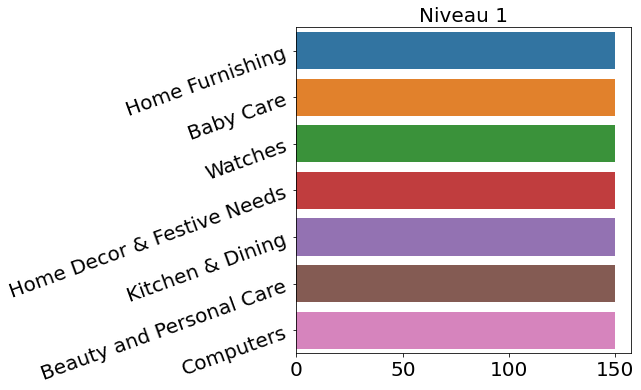

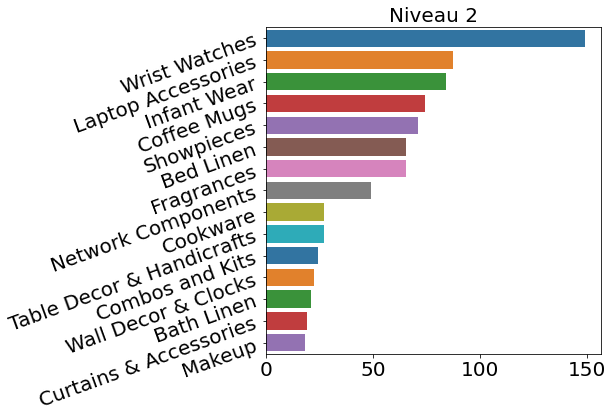

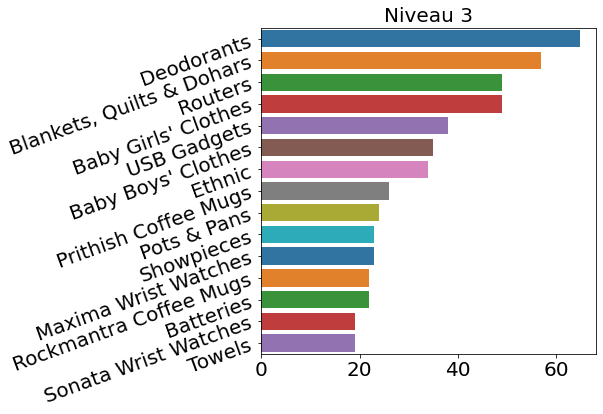

In [108]:
#Distribution des niveaux de catégories
#Niveau 1
plt.figure(figsize=(6,6))
categorie_1 = sns.countplot(y=data_T['niveau_categorie_1'],
                     order=data_T['niveau_categorie_1'].value_counts().iloc[:15].index,
                     palette='tab10')
categorie_1.axes.set_title("Niveau 1",fontsize=20)
categorie_1.set_ylabel("",fontsize=20)
categorie_1.set_xlabel("",fontsize=20)
plt.yticks(rotation=20)
categorie_1.tick_params(labelsize=20)
plt.savefig("niveau_1.png", bbox_inches="tight")
plt.show()

#Niveau 2
plt.figure(figsize=(6,6))
categorie_2 = sns.countplot(y=data_T['niveau_categorie_2'],
                     order=data_T['niveau_categorie_2'].value_counts().iloc[:15].index,
                     palette='tab10')
categorie_2.axes.set_title("Niveau 2",fontsize=20)
categorie_2.set_ylabel("",fontsize=20)
categorie_2.set_xlabel("",fontsize=20)
plt.yticks(rotation=20)
categorie_2.tick_params(labelsize=20)
plt.savefig("niveau_2.png", bbox_inches="tight")
plt.show()

#Niveau 3
plt.figure(figsize=(6, 6))
categorie_3 = sns.countplot(y=data_T['niveau_categorie_3'],
                     order=data_T['niveau_categorie_3'].value_counts().iloc[:15].index,
                     palette='tab10')
categorie_3.axes.set_title("Niveau 3",fontsize=20)
categorie_3.set_ylabel("",fontsize=20)
categorie_3.set_xlabel("",fontsize=20)
plt.yticks(rotation=20)
categorie_3.tick_params(labelsize=20)
plt.savefig("niveau_3.png", bbox_inches="tight")
plt.show()



### <font color="blue" id="section_1_c">c. Variable "description" : premières modifications </font>

Voyons maintenant la variable "description", elle décrit le produit et nécessite surement un nettoyage pour pouvoir être
modélisé.

In [13]:
#Regardons à quoi ressemble la variable "description"
data_T['description']

0       Key Features of Elegance Polyester Multicolor ...
1       Specifications of Sathiyas Cotton Bath Towel (...
2       Key Features of Eurospa Cotton Terry Face Towe...
3       Key Features of SANTOSH ROYAL FASHION Cotton P...
4       Key Features of Jaipur Print Cotton Floral Kin...
5       Maserati Time R8851116001 Analog Watch  - For ...
6       Camerii WM64 Elegance Analog Watch  - For Men,...
7       T STAR UFT-TSW-005-BK-BR Analog Watch  - For B...
8       Alfajr WY16B Youth Digital Watch  - For Men, B...
9       TAG Heuer CAU1116.BA0858 Formula 1 Analog Watc...
10      Calibro SW-125 Analog-Digital Watch  - For Men...
11      Cartier W6701005 Analog Watch  - For Boys, Men...
12      Lois Caron LCS-4032 Analog Watch  - For Boys, ...
13      Titan 1639SL03 Analog Watch  - For Boys, Men -...
14      Srushti Art Jewelry Megnet_Led_Sport_BlackRed1...
15      Escort E-1700-906_Blk Analog Watch  - For Men,...
16      Jack klein BlackLed Digital Watch  - For Boys ...
17      North 

In [14]:
#Voyons maintenant la première modalité de la variable "description"
data_T['description'][0]

'Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegance Polyester Multicolor Abstract Eyelet Door Curtain (213 cm in Height, Pack of 2) Price: Rs. 899 This curtain enhances the look of the interiors.This curtain is made from 100% high quality polyester fabric.It features an eyelet style stitch with Metal Ring.It makes the room environment romantic and loving.This curtain is ant- wrinkle and anti shrinkage and have elegant apparance.Give your home a bright and modernistic appeal with these designs. The surreal attention is sure to steal hearts. These contemporary eyelet and valance curtains slide smoothly so when you draw them apart first thing in the morning to welcome the bright sun rays you want to wish good morning to the whole world and when you draw them close in the evening, you create the most special moments of joyous beauty given by the soothing prints. Bring home the elegant curtain that softly filters light in your room so that you

On remarque la présence des majuscules/minuscules dans le texte, des ponctuations, des signes (%, &), des chiffres, et des "mots vides"
(of, for, to, etc...)

In [15]:
#Regardons le texte toutes lignes confondues de cette variable
texte = np.array([])

for i in data_T['description']:
    texte = np.append(data_T['description'], i)

print(texte)

['Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegance Polyester Multicolor Abstract Eyelet Door Curtain (213 cm in Height, Pack of 2) Price: Rs. 899 This curtain enhances the look of the interiors.This curtain is made from 100% high quality polyester fabric.It features an eyelet style stitch with Metal Ring.It makes the room environment romantic and loving.This curtain is ant- wrinkle and anti shrinkage and have elegant apparance.Give your home a bright and modernistic appeal with these designs. The surreal attention is sure to steal hearts. These contemporary eyelet and valance curtains slide smoothly so when you draw them apart first thing in the morning to welcome the bright sun rays you want to wish good morning to the whole world and when you draw them close in the evening, you create the most special moments of joyous beauty given by the soothing prints. Bring home the elegant curtain that softly filters light in your room so that yo

## <font color="red" id="section_2">2. Nettoyage et préparation du texte </font>

Voyons avant nettoyage, le nuage de mots de la variable "description". Cela nous donnera une idée des mots les plus
utilisés dans notre variable.

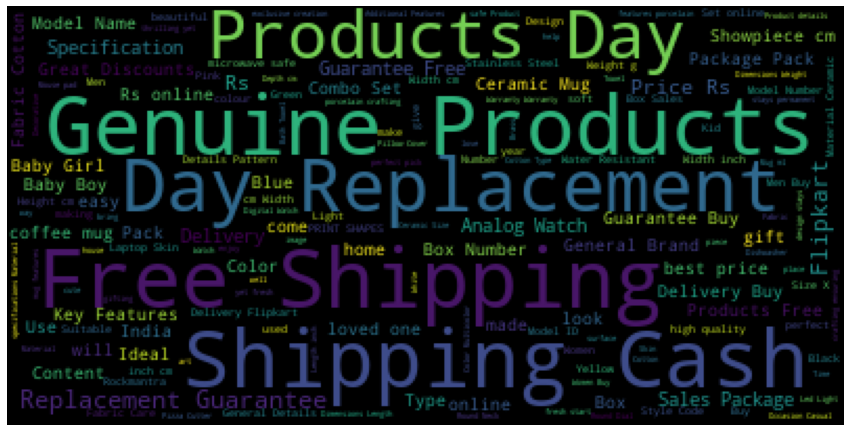

In [16]:
# Nuage de mots de "description"
from wordcloud import WordCloud, ImageColorGenerator

texte = " ".join([mot for mot in data_T['description']])
# nuage de mots:
nuage_de_mots = WordCloud(max_font_size=40, max_words=500).generate(texte)

# Afficher l'image générée:
plt.figure(figsize= [15,12])
plt.imshow(nuage_de_mots)
plt.axis("off")
plt.show()

### <font color="blue" id="section_2_a">a. Nettoyage du texte</font>

A l'aide des fonctions ci-dessous, nous allons créer 3 variables qui nous serviront pour les différentes approches 
que nous allons tester ensuite :</br>
    - "sentence_bow" : le texte est transformé pour être préparé pour le bag of word (Countvectorizer et Tf_idf, Word2Vec)</br>
    - "sentence_bow_lem" : même transformation, avec plus une lemmatization</br>
    - "sentence_dl" : le texte est transformé pour le deep learning (bert et USE)</br>
    
Nous allons appliqué divers modification du texte : on tokenize le texte (divisions du texte), on supprime les stop words
ou mots vides, on uniformise les mots en les mettant tous en minuscule, et on lemmatize les mots (on ne garde que les
radicales des mots pour ne pas avoir de doublons de mots identiques).
    

In [17]:
# Tokenizer
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize

def tokenizer_fct(sentence) :
    # print(sentence)
    sentence_clean = sentence.replace('-', ' ').replace('+', ' ').replace('/', ' ').replace('#', ' ')
    word_tokens = word_tokenize(sentence_clean)
    return word_tokens

# Stop words
from nltk.corpus import stopwords
stop_w = list(set(stopwords.words('english'))) + ['[', ']', ',', '.', ':', '?', '(', ')']

def stop_word_filter_fct(list_words) :
    filtered_w = [w for w in list_words if not w in stop_w]
    filtered_w2 = [w for w in filtered_w if len(w) > 2]
    return filtered_w2

# lower case et alpha
def lower_start_fct(list_words) :
    lw = [w.lower() for w in list_words if (not w.startswith("@")) 
    #                                   and (not w.startswith("#"))
                                       and (not w.startswith("http"))]
    return lw

# Lemmatizer (base d'un mot)
from nltk.stem import WordNetLemmatizer

def lemma_fct(list_words) :
    lemmatizer = WordNetLemmatizer()
    lem_w = [lemmatizer.lemmatize(w) for w in list_words]
    return lem_w

# Fonction de préparation du texte pour le bag of words (Countvectorizer et Tf_idf, Word2Vec)
def transform_bow_fct(desc_text) :
    word_tokens = tokenizer_fct(desc_text)
    sw = stop_word_filter_fct(word_tokens)
    lw = lower_start_fct(sw)
    # lem_w = lemma_fct(lw)    
    transf_desc_text = ' '.join(lw)
    return transf_desc_text

# Fonction de préparation du texte pour le bag of words avec lemmatization
def transform_bow_lem_fct(desc_text) :
    word_tokens = tokenizer_fct(desc_text)
    sw = stop_word_filter_fct(word_tokens)
    lw = lower_start_fct(sw)
    lem_w = lemma_fct(lw)    
    transf_desc_text = ' '.join(lem_w)
    return transf_desc_text

# Fonction de préparation du texte pour le Deep learning (USE et BERT)
def transform_dl_fct(desc_text) :
    word_tokens = tokenizer_fct(desc_text)
#    sw = stop_word_filter_fct(word_tokens)
    lw = lower_start_fct(word_tokens)
    # lem_w = lemma_fct(lw)    
    transf_desc_text = ' '.join(lw)
    return transf_desc_text

In [18]:
data_T['sentence_bow'] = data_T['description'].apply(lambda x : transform_bow_fct(x))
data_T['sentence_bow_lem'] = data_T['description'].apply(lambda x : transform_bow_lem_fct(x))
data_T['sentence_dl'] = data_T['description'].apply(lambda x : transform_dl_fct(x))
data_T.shape

(1050, 22)

In [25]:
from nltk.tokenize import sent_tokenize, word_tokenize

data_T['length_bow'] = data_T['sentence_bow'].apply(lambda x : len(word_tokenize(x)))
print("max length bow : ", data_T['length_bow'].max())
data_T['length_dl'] = data_T['sentence_dl'].apply(lambda x : len(word_tokenize(x)))
print("max length dl : ", data_T['length_dl'].max())

max length bow :  379
max length dl :  632


In [19]:
data_T['sentence_bow_lem']

0       key feature elegance polyester multicolor abst...
1       specification sathiyas cotton bath towel bath ...
2       key feature eurospa cotton terry face towel se...
3       key feature santosh royal fashion cotton print...
4       key feature jaipur print cotton floral king si...
5       maserati time r8851116001 analog watch for boy...
6       camerii wm64 elegance analog watch for men boy...
7       star uft tsw 005 analog watch for boy price 39...
8       alfajr wy16b youth digital watch for men boy b...
9       tag heuer cau1116.ba0858 formula analog watch ...
10      calibro 125 analog digital watch for men boy p...
11      cartier w6701005 analog watch for boy men buy ...
12      lois caron lcs 4032 analog watch for boy men b...
13      titan 1639sl03 analog watch for boy men buy ti...
14      srushti art jewelry megnet_led_sport_blackred1...
15      escort 1700 906_blk analog watch for men boy p...
16      jack klein blackled digital watch for boy buy ...
17      north 

On va générer un nuage de mots des mots présents dans la variable "description" après nettoyage du texte.

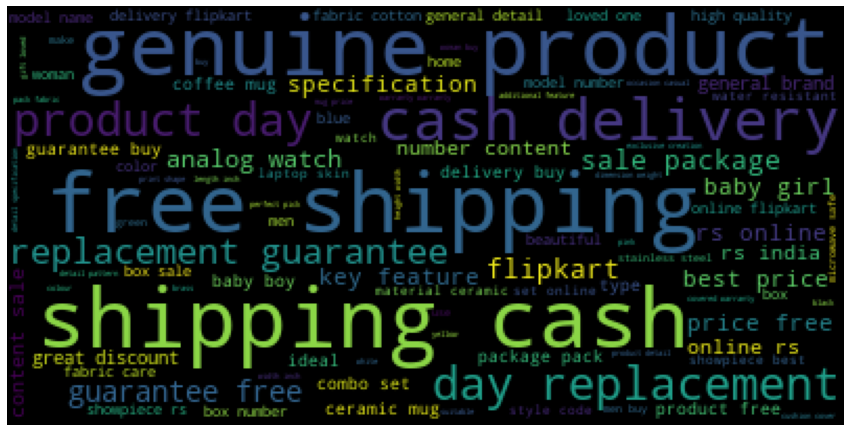

In [20]:
# Nuage de mots de "description"
from wordcloud import WordCloud, ImageColorGenerator

texte = " ".join([mot for mot in data_T['sentence_bow_lem']])
# nuage de mots:
nuage_de_mots = WordCloud(max_font_size=40, max_words=500).generate(texte)

# Afficher l'image générée:
plt.figure(figsize= [15,12])
plt.imshow(nuage_de_mots)
plt.axis("off")
plt.show()

Nous allons maintenant voir ce que les nuages de mots des descriptions donnent par catégories de produits.

Nous allons croisé par les catégories de produits de niveau 1 "niveau_categorie_1".

In [21]:
#catégories présentes dans notre data
data_T["niveau_categorie_1"].value_counts()

Home Furnishing               150
Baby Care                     150
Watches                       150
Home Decor & Festive Needs    150
Kitchen & Dining              150
Beauty and Personal Care      150
Computers                     150
Name: niveau_categorie_1, dtype: int64

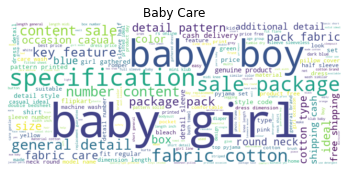

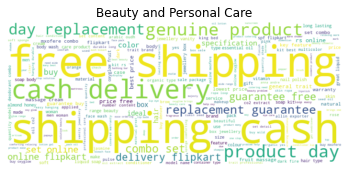

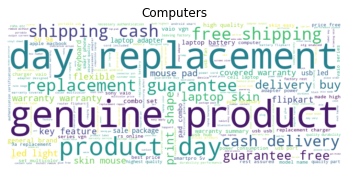

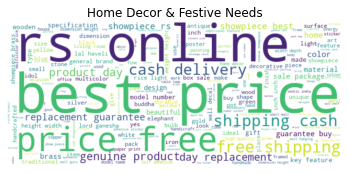

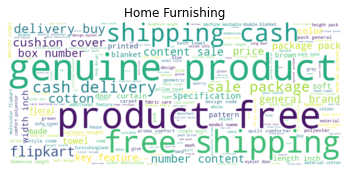

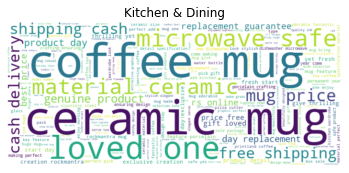

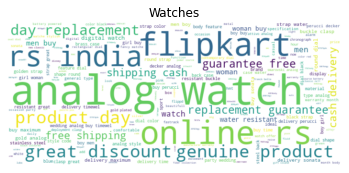

In [22]:
desc_par_cat = data_T.groupby(['niveau_categorie_1'])['sentence_bow_lem'].apply(' '.join).reset_index()

nuage_de_mots = WordCloud(width = 700 ,height = 300 , background_color="white" )

for k in range(0,7):
  text = desc_par_cat.iloc[k]['sentence_bow_lem']
  nuage_de_mots.generate(text)
  plt.imshow(nuage_de_mots, interpolation='bilinear')
  plt.axis("off")
  plt.title(desc_par_cat.iloc[k]['niveau_categorie_1'])
  plt.show()

## Fonctions nécessaires pour les différentes approches utilisées

Pour la suite de notre projet, nous allons tester différentes approches : 
- deux approches de type “bag-of-words”, comptage simple de mots (avec CountVectorizer) et Tf-idf ;
- une approche de type word/sentence embedding classique avec Word2Vec ;
- une approche de type word/sentence embedding avec BERT ;
- une approche de type word/sentence embedding avec USE (Universal Sentence Encoder). </br>

Pour pouvoir comparer ces approches, nous allons pour chacune d'elle, calculer le Tsne, déterminer des clusters 
en utilisant le Kmeans, et calculer un score ARI qui nous permettra de comparer le réel avec nos vrais catégories et
les clusters créés avec le Kmeans.


In [24]:
import time
from sklearn import manifold, decomposition
from sklearn import cluster, metrics


#catégories
l_cat = []
for i in range(len(data_T)):
    cat = data_T['product_category_tree'][i].split('>>')[0][2:]
    l_cat.append(cat)

l_cat = list(dict.fromkeys(l_cat))

for i in l_cat:
    stop_word_filter_fct(i)

print("catégories : ", l_cat)
y_cat_num = [(1-l_cat.index(data_T.iloc[i]['product_category_tree'].split('>>')[0][2:])) for i in range(len(data_T))]


catégories :  ['Home Furnishing ', 'Baby Care ', 'Watches ', 'Home Decor & Festive Needs ', 'Kitchen & Dining ', 'Beauty and Personal Care ', 'Computers ']


In [23]:
# Calcul Tsne, détermination des clusters et calcul ARI entre vrais catégorie et n° de clusters
def ARI_fct(features) :
    time1 = time.time()
    num_labels=len(l_cat)
    tsne = manifold.TSNE(n_components=2, perplexity=30, n_iter=2000, 
                                 init='random', learning_rate=200, random_state=42)
    X_tsne = tsne.fit_transform(features)
    
    # Détermination des clusters à partir des données après Tsne 
    cls = cluster.KMeans(n_clusters=num_labels, n_init=100, random_state=42)
    cls.fit(X_tsne)
    ARI = np.round(metrics.adjusted_rand_score(y_cat_num, cls.labels_),4)
    time2 = np.round(time.time() - time1,0)
    print("ARI : ", ARI, "time : ", time2)
    
    return ARI, X_tsne, cls.labels_


# visualisation du Tsne selon les vraies catégories et selon les clusters
def TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI) :
    fig = plt.figure(figsize=(15,6))
    
    ax = fig.add_subplot(121)
    scatter = ax.scatter(X_tsne[:,0],X_tsne[:,1], c=y_cat_num, cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[0], labels=l_cat, loc="best", title="Categorie")
    plt.title('Représentation des descriptions par catégories réelles')
    
    ax = fig.add_subplot(122)
    scatter = ax.scatter(X_tsne[:,0],X_tsne[:,1], c=labels, cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[0], labels=set(labels), loc="best", title="Clusters")
    plt.title('Représentation des descriptions par clusters')
    
    plt.show()
    print("ARI : ", ARI)

### <font color="blue" id="section_2_b">b. Premier type d'approche Bag of word : comptage simple de mots (CountVectorizer)</font>

Cette étape consiste à encoder les chaînes de caractère par rapport au vocabulaire constitué précédemment. C'est ce qu'on appelle le "bag of word".
CountVectorizer est utilisé pour transformer un texte donné en vecteur sur la base de la fréquence (nombre) de chaque mot qui apparaît dans tout le texte. 

## Exécution des modèles

In [26]:
# création du bag of words (CountVectorizer)
from sklearn.feature_extraction.text import CountVectorizer

#On ignore tous les mots qui apparaissent dans plus 95% du document et on ignore tous les termes qui apparaissent dans
#moins de 100% du document
cvect = CountVectorizer(stop_words='english', max_df=0.95, min_df=1)

feat = 'sentence_bow_lem'
#On entraine le modèle
cv_fit = cvect.fit(data_T[feat])

#On transforme le modèle
cv_transform = cvect.transform(data_T[feat])  

In [27]:
# execution :
print("CountVectorizer : ")
print("-----------------")
ARI_cv, X_tsne_cv, labels = ARI_fct(cv_transform)
print()

CountVectorizer : 
-----------------
ARI :  0.3842 time :  21.0



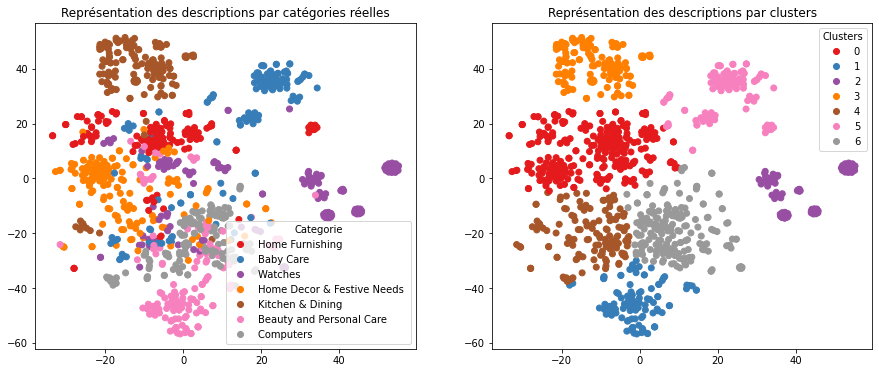

ARI :  0.3842


In [28]:
# graphique :

TSNE_visu_fct(X_tsne_cv, y_cat_num, labels, ARI_cv)

### <font color="blue" id="section_2_c">c. Deuxième type d'approche Bag of World: Tf-idf </font>

Le TF-IDF ('term frequency-inverse document frequency') est une méthode de **pondération** souvent utilisée
           en recherche d'information et en particulier dans la fouille de textes. Cette mesure statistique permet
           d'**évaluer l'importance d'un terme contenu dans un document**, relativement à une collection ou un corpus.
           Le poids augmente proportionnellement au nombre d'occurrences du mot dans le document.
           Il varie également en fonction de la fréquence du mot dans le corpus.

In [29]:
# création du bag of words (Tf-idf)
from sklearn.feature_extraction.text import TfidfVectorizer

ctf = TfidfVectorizer(stop_words='english', max_df=0.95, min_df=1)

feat = 'sentence_bow_lem'
ctf_fit = ctf.fit(data_T[feat])

ctf_transform = ctf.transform(data_T[feat])

In [30]:
print("Tf-idf : ")
print("--------")
ARI_ctf, X_tsne_ctf, labels = ARI_fct(ctf_transform)

Tf-idf : 
--------
ARI :  0.4282 time :  22.0


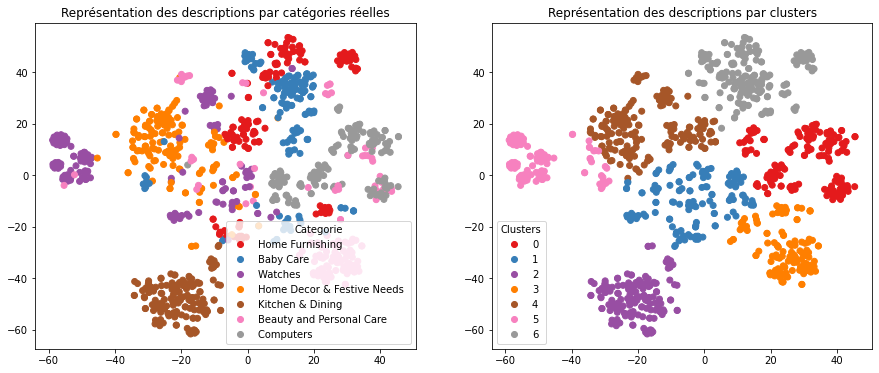

ARI :  0.4282


In [31]:
# graphique :

TSNE_visu_fct(X_tsne_ctf, y_cat_num, labels, ARI_ctf)

### <font color="blue" id="section_2_d">d. Troisième approche de type word/sentence embedding classique avec Word2Vec </font>

Le **word embedding** est  une technique de modélisation du langage utilisée pour mapper 
des mots sur des vecteurs de nombres réels. Il représente des mots ou des phrases dans un espace vectoriel 
à plusieurs dimensions.

**Word2vec** est une technique de traitement du langage naturel publiée en 2013. L'algorithme word2vec utilise un 
modèle de réseau de neurones pour apprendre les associations de mots à partir d'un large corpus de texte .
Une fois entraîné, un tel modèle peut détecter des mots synonymes ou suggérer des mots supplémentaires pour 
une phrase partielle. Comme son nom l'indique, word2vec représente chaque mot distinct avec une liste particulière 
de nombres appelée vecteur . Les vecteurs sont choisis avec soin de telle sorte qu'une simple fonction mathématique 
(la similarité en cosinus entre les vecteurs) indique le niveau de similarité sémantique entre les mots représentés 
par ces vecteurs.

In [32]:
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras import backend as K

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
import gensim

## Création du modèle Word2Vec

In [33]:
w2v_size=300
w2v_window=5
w2v_min_count=1
w2v_epochs=100
maxlen = 200 # adapt to length of sentences
sentences = data_T['sentence_bow_lem'].to_list()
sentences = [gensim.utils.simple_preprocess(text) for text in sentences]

In [34]:
# Création et entraînement du modèle Word2Vec

print("Build & train Word2Vec model ...")
w2v_model = gensim.models.Word2Vec(min_count=w2v_min_count, window=w2v_window,
                                                vector_size=w2v_size,
                                                seed=42,
                                                workers=1)
#                                                workers=multiprocessing.cpu_count())
w2v_model.build_vocab(sentences)
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=w2v_epochs)
model_vectors = w2v_model.wv
w2v_words = model_vectors.index_to_key
print("Vocabulary size: %i" % len(w2v_words))
print("Word2Vec trained")

Build & train Word2Vec model ...
Vocabulary size: 4712
Word2Vec trained


In [35]:
# Préparation des sentences (tokenization)

print("Fit Tokenizer ...")
tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)
x_sentences = pad_sequences(tokenizer.texts_to_sequences(sentences),
                                                     maxlen=maxlen,
                                                     padding='post') 
                                                   
num_words = len(tokenizer.word_index) + 1
print("Number of unique words: %i" % num_words)

Fit Tokenizer ...
Number of unique words: 4713


## Création de la matrice d'embedding

In [36]:
# Création de la matrice d'embedding

print("Create Embedding matrix ...")
w2v_size = 300
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1
embedding_matrix = np.zeros((vocab_size, w2v_size))
i=0
j=0
    
for word, idx in word_index.items():
    i +=1
    if word in w2v_words:
        j +=1
        embedding_vector = model_vectors[word]
        if embedding_vector is not None:
            embedding_matrix[idx] = model_vectors[word]
            
word_rate = np.round(j/i,4)
print("Word embedding rate : ", word_rate)
print("Embedding matrix: %s" % str(embedding_matrix.shape))

Create Embedding matrix ...
Word embedding rate :  1.0
Embedding matrix: (4713, 300)


## Création du modèle d'embedding

In [37]:
# Création du modèle

input=Input(shape=(len(x_sentences),maxlen),dtype='float64')
word_input=Input(shape=(maxlen,),dtype='float64')  
word_embedding=Embedding(input_dim=vocab_size,
                         output_dim=w2v_size,
                         weights = [embedding_matrix],
                         input_length=maxlen)(word_input)
word_vec=GlobalAveragePooling1D()(word_embedding)  
embed_model = Model([word_input],word_vec)

embed_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 200)]             0         
                                                                 
 embedding (Embedding)       (None, 200, 300)          1413900   
                                                                 
 global_average_pooling1d (G  (None, 300)              0         
 lobalAveragePooling1D)                                          
                                                                 
Total params: 1,413,900
Trainable params: 1,413,900
Non-trainable params: 0
_________________________________________________________________


## Exécution du modèle

In [38]:
embeddings = embed_model.predict(x_sentences)
embeddings.shape

33/33 [==============================] - 0s 4ms/step


(1050, 300)

In [39]:
ARI_w2v, X_tsne, labels = ARI_fct(embeddings)

ARI :  0.3288 time :  19.0


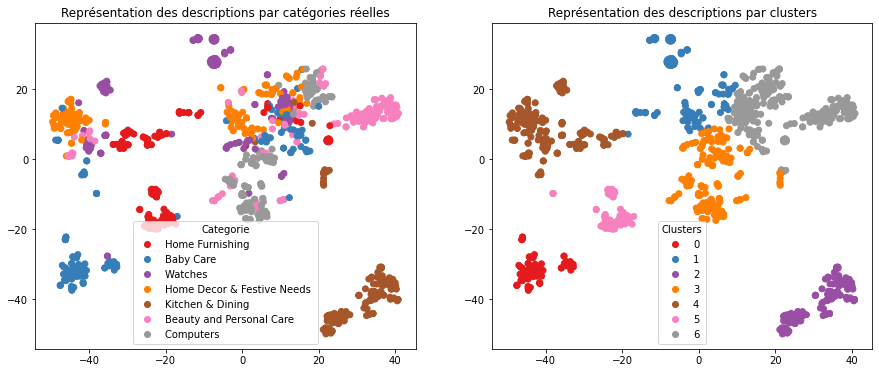

ARI :  0.3288


In [40]:
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI_w2v)

### <font color="blue" id="section_2_e">e. Une autre approche de type word/sentence embedding classique avec BERT </font>

Bert est un modèle de type Transformers. Un transformer est un modèle qui fonctionne en effectuant un petit nombre constant d’étapes. À chaque étape, il applique un mécanisme d’attention pour comprendre les relations entre les mots de la phrase, quelles que soient leurs positions respectives. Prenons un exemple simple : 

    “Tu as une nouvelle souris pour ton ordinateur ? “

Pour déterminer le sens du mot souris, l’objet et non l’animal, le transformer va prêter attention au mot “ordinateur” et prendre une décision en une étape basée sur ça. 

Pour permettre cela, BERT se base donc sur l’architecture des transformers, c’est-à-dire consistant en un encodeur pour lire le texte et un décodeur pour faire une prédiction. BERT se limite à un encodeur, car son objectif est de créer un modèle de représentation du langage qui sera ensuite utilisable pour des tâches de NLP. (Il permet de comprendre le langage).


In [41]:
import tensorflow as tf
# import tensorflow_hub as hub
import tensorflow.keras
from tensorflow.keras import backend as K

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

# Bert
import os
import transformers
from transformers import *

os.environ["TF_KERAS"]='1'

In [42]:
print(tf.__version__)
print(tensorflow.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print(tf.test.is_built_with_cuda())

2.9.1
2.9.1
Num GPUs Available:  0
True


## Fonctions communes

Bert a été préformé uniquement sur les textes bruts, sans qu'aucun humain ne les étiquette de quelque manière que ce soit (c'est pourquoi il peut utiliser de nombreuses données accessibles au public) avec un processus automatique pour générer des entrées et des étiquettes à partir de ces textes. Plus précisément, il a été préformé avec deux objectifs :

- Modélisation du langage masqué (MLM).
- Prédiction de la phrase suivante (NSP).

In [43]:
# Fonction de préparation des sentences
def bert_inp_fct(sentences, bert_tokenizer, max_length) :
    input_ids=[]
    token_type_ids = []
    attention_mask=[]
    bert_inp_tot = []

    for sent in sentences:
        bert_inp = bert_tokenizer.encode_plus(sent,
                                              add_special_tokens = True,
                                              max_length = max_length,
                                              padding='max_length',
                                              return_attention_mask = True, 
                                              return_token_type_ids=True,
                                              truncation=True,
                                              return_tensors="tf")
    
        input_ids.append(bert_inp['input_ids'][0])
        token_type_ids.append(bert_inp['token_type_ids'][0])
        attention_mask.append(bert_inp['attention_mask'][0])
        bert_inp_tot.append((bert_inp['input_ids'][0], 
                             bert_inp['token_type_ids'][0], 
                             bert_inp['attention_mask'][0]))

    input_ids = np.asarray(input_ids)
    token_type_ids = np.asarray(token_type_ids)
    attention_mask = np.array(attention_mask)
    
    return input_ids, token_type_ids, attention_mask, bert_inp_tot
    

# Fonction de création des features
def feature_BERT_fct(model, model_type, sentences, max_length, b_size, mode='HF') :
    batch_size = b_size
    batch_size_pred = b_size
    bert_tokenizer = AutoTokenizer.from_pretrained(model_type)
    time1 = time.time()

    for step in range(len(sentences)//batch_size) :
        idx = step*batch_size
        input_ids, token_type_ids, attention_mask, bert_inp_tot = bert_inp_fct(sentences[idx:idx+batch_size], 
                                                                      bert_tokenizer, max_length)
        
        if mode=='HF' :    # Bert HuggingFace
            outputs = model.predict([input_ids, attention_mask, token_type_ids], batch_size=batch_size_pred)
            last_hidden_states = outputs.last_hidden_state

        if mode=='TFhub' : # Bert Tensorflow Hub
            text_preprocessed = {"input_word_ids" : input_ids, 
                                 "input_mask" : attention_mask, 
                                 "input_type_ids" : token_type_ids}
            outputs = model(text_preprocessed)
            last_hidden_states = outputs['sequence_output']
             
        if step ==0 :
            last_hidden_states_tot = last_hidden_states
            last_hidden_states_tot_0 = last_hidden_states
        else :
            last_hidden_states_tot = np.concatenate((last_hidden_states_tot,last_hidden_states))
    
    features_bert = np.array(last_hidden_states_tot).mean(axis=1)
    
    time2 = np.round(time.time() - time1,0)
    print("temps traitement : ", time2)
     
    return features_bert, last_hidden_states_tot

## BERT HuggingFace

Hugging Face a construit toute une API pour faciliter l'utilisation des transformers. La librairie propose des pipelines pré-définies et une bibliothèque de modèles explorables par tâches et langue et de datasets prêts à l'emploi. L'avantage de Hugging Face est la grande diversité de modèles expérimentaux ou éprouvés qui sont disponibles sur le hub et la facilité d'utilisation et d'expérimentation qu'il permet.

Le package Transformers de Hugging Face est utilisé pour l'analyse des sentiments, la traduction, la classification de texte zéro-shot, le résumé, et la reconnaissance d'entités nommées (anglais et français)

### 'bert-base-uncased'

In [44]:
## bert_base_uncased
max_length = 64
batch_size = 10
model_type = 'bert-base-uncased'
model = TFAutoModel.from_pretrained(model_type)


In [45]:
sentences = data_T['sentence_dl'].to_list()


In [46]:
# Création des features

features_bert, last_hidden_states_tot = feature_BERT_fct(model, model_type, sentences, 
                                                         max_length, batch_size, mode='HF')

1/1 [==============================] - 2s 2s/step
temps traitement :  210.0


In [47]:
ARI_bert, X_tsne, labels = ARI_fct(features_bert)

ARI :  0.3281 time :  19.0


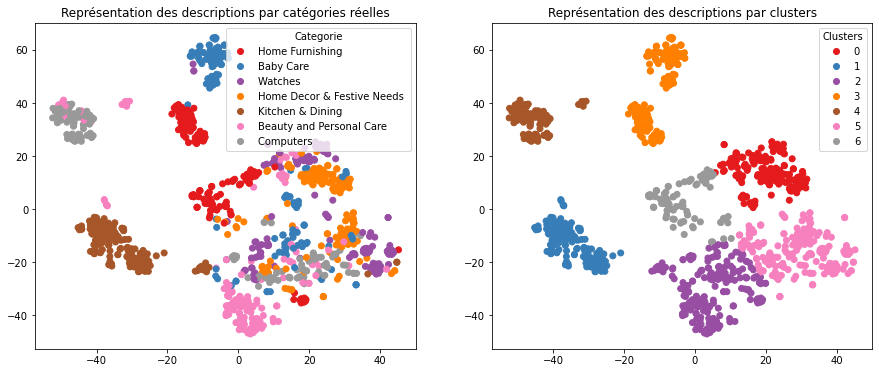

ARI :  0.3281


In [48]:
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI_bert)

## BERT hub Tensorflow

C'est une librairie qui permet d'accéder à des modèles disponible sur TensorFlow Hub. En fait, TensorFlow Hub est un site répertoriant des modèles officiels de Machine Learning préentraînés aussi bien dans le domaine du NLP mais pour la Vision par ordinateur et bien d'autres.

In [49]:
import tensorflow_hub as hub
import tensorflow_text 

# Guide sur le Tensorflow hub : https://www.tensorflow.org/text/tutorials/classify_text_with_bert
model_url = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4'
bert_layer = hub.KerasLayer(model_url, trainable=True)

In [50]:
sentences = data_T['sentence_dl'].to_list()

In [51]:
max_length = 64
batch_size = 10
model_type = 'bert-base-uncased'
model = bert_layer

features_bert, last_hidden_states_tot = feature_BERT_fct(model, model_type, sentences, 
                                                         max_length, batch_size, mode='TFhub')

temps traitement :  216.0


In [52]:
ARI_hub, X_tsne, labels = ARI_fct(features_bert)

ARI :  0.3148 time :  19.0


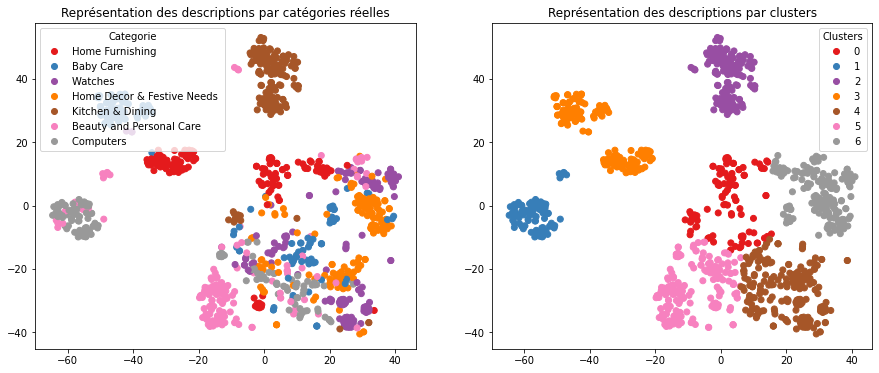

ARI :  0.3148


In [53]:
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI_hub)

# USE - Universal Sentence Encoder

Universal Sentence Encoder code une phrase ou un texte entier en vecteurs de nombres réels qui peuvent être utilisés pour le regroupement, la similarité de phrases, la classification de texte et d'autres tâches de traitement du langage naturel (NLP).

In [54]:
import tensorflow as tf
# import tensorflow_hub as hub
import tensorflow.keras
from tensorflow.keras import backend as K

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import metrics as kmetrics
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

# Bert
import transformers
from transformers import *

os.environ["TF_KERAS"]='1'

In [55]:
print(tf.__version__)
print(tensorflow.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print(tf.test.is_built_with_cuda())

2.9.1
2.9.1
Num GPUs Available:  0
True


In [56]:
import tensorflow_hub as hub

embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

In [57]:
def feature_USE_fct(sentences, b_size) :
    batch_size = b_size
    time1 = time.time()

    for step in range(len(sentences)//batch_size) :
        idx = step*batch_size
        feat = embed(sentences[idx:idx+batch_size])

        if step ==0 :
            features = feat
        else :
            features = np.concatenate((features,feat))

    time2 = np.round(time.time() - time1,0)
    return features

In [58]:
batch_size = 10
sentences = data_T['sentence_dl'].to_list()

In [59]:
features_USE = feature_USE_fct(sentences, batch_size)

In [60]:
ARI_USE, X_tsne_USE, labels = ARI_fct(features_USE)

ARI :  0.4409 time :  19.0


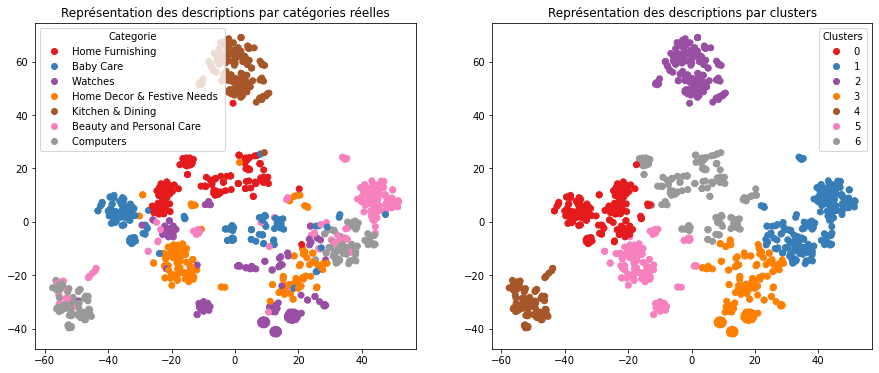

ARI :  0.4409


In [61]:
TSNE_visu_fct(X_tsne_USE, y_cat_num, labels, ARI_USE)

### Comparaison des scores ARI

Nous allons maintenant comparer les scores ARI de chacune de ces approches.
Nous verrons ainsi quelle approche à des clusters qui se rapprochent le plus des regroupements fait par les catégories.

In [62]:
ARI = pd.DataFrame([[ARI_cv, ARI_ctf, ARI_w2v, ARI_bert, ARI_hub, ARI_USE]],columns=['ARI_cv', 'ARI_ctf',
                                                                                          'ARI_w2v', 'ARI_bert',
                                                                                          'ARI_hub', 'ARI_USE'])
ARI

ARI_cv  ARI_ctf  ARI_w2v  ARI_bert  ARI_hub  ARI_USE
0  0.3842   0.4282   0.3288    0.3281   0.3148   0.4409

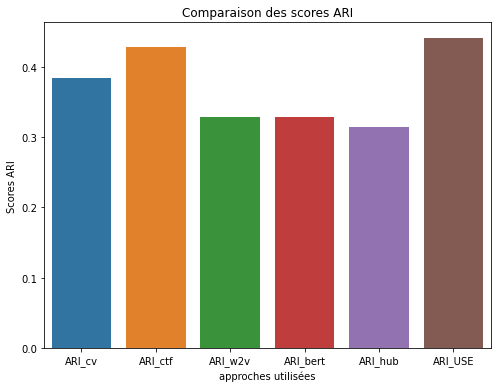

In [63]:
#Représentation graphique des scores ARI selon les différentes approches utilisées

fig = plt.figure(figsize=(8, 6))
sns.barplot(data=ARI)
plt.xlabel("approches utilisées")
plt.ylabel("Scores ARI")
plt.title("Comparaison des scores ARI")
plt.show()

Les scores ARI tf-idf et USE sont les plus importants. Ce qui signifie que les clusters se rapprochent le plus des regroupements
de catégories. 

### Matrice de confusion

Regardons d'abord la répartitions des mots par groupes pour les 2 approches qui ont le meilleur score.

### Tf_idf

In [64]:
#On crée une dataframe contenant les valeurs du tsne ainsi que les catégories de produits
df_tsne_ctf = pd.DataFrame(X_tsne_cv[:,0:2], columns=['tsne1', 'tsne2'])
df_tsne_ctf["class"] = data_T['niveau_categorie_1']
print(df_tsne_ctf.shape)

(1050, 3)


In [65]:
#On clusterise les données en 7 regroupements
from sklearn import cluster, metrics

cls = cluster.KMeans(n_clusters=7, random_state=6)
cls.fit(X_tsne_ctf)

df_tsne_ctf["cluster"] = cls.labels_

In [66]:
#Nombre de valeurs par cluster
df_tsne_ctf.groupby("cluster").count()["class"]



cluster
0    130
1    102
2    184
3    151
4    157
5    141
6    185
Name: class, dtype: int64

In [120]:
#fonction qui calcule la matrice de confusion du modèle

from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder


def matrice_de_confusion(data,
                        y_true='class',
                        y_pred='cluster',
                        xlabel='cluster',
                        ylabel='Categories de produits'):
    
    
    le_true = LabelEncoder()
    le_pred = LabelEncoder()
    y_true= le_true.fit_transform(data[y_true])
    y_pred = le_pred.fit_transform(data[y_pred])
    
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(8,8))
    sns.heatmap(cm,
                fmt="d",
                annot=True,
                linewidths=.5,
                xticklabels=le_pred.classes_,
                yticklabels=le_true.classes_)
    plt.xlabel(xlabel, fontsize=16)
    plt.ylabel(ylabel, fontsize=16)
    plt.title('Confusion Matrix', fontsize=24)
    plt.show()

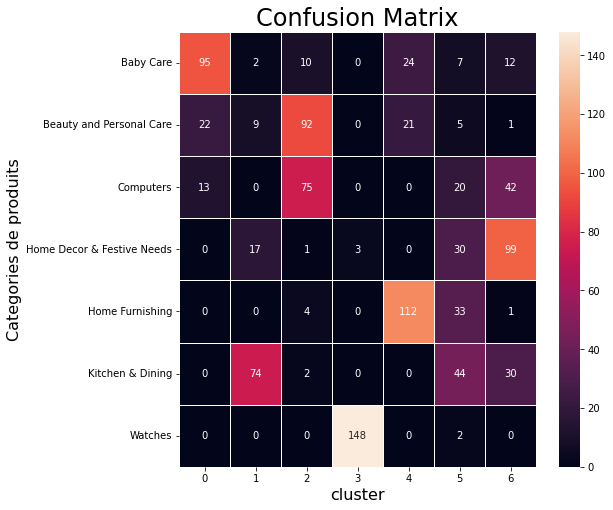

In [121]:
matrice_de_confusion(df_tsne_ctf)



### USE

In [69]:
#On crée une dataframe contenant les valeurs du tsne ainsi que les catégories de produits
df_tsne_USE = pd.DataFrame(X_tsne_cv[:,0:2], columns=['tsne1', 'tsne2'])
df_tsne_USE["class"] = data_T['niveau_categorie_1']
print(df_tsne_USE.shape)

(1050, 3)


In [70]:
#On clusterise les données en 7 regroupements à l'aide du kmeans
from sklearn import cluster, metrics

cls = cluster.KMeans(n_clusters=7, random_state=6)
cls.fit(X_tsne_USE)

df_tsne_USE["cluster"] = cls.labels_

In [71]:
#Nombre de valeurs par cluster
df_tsne_USE.groupby("cluster").count()["class"]

cluster
0    202
1    118
2    150
3    160
4     95
5    165
6    160
Name: class, dtype: int64

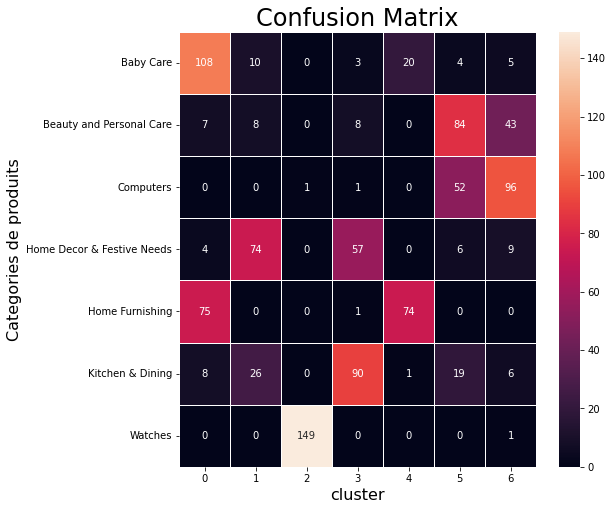

In [122]:
matrice_de_confusion(df_tsne_USE)

# Deuxième partie : Partie Image

Dans cette partie, nous aurons besoin d'extraire les features image.

Afin d’extraire les features image, nous allons mettre en œuvre :

- un algorithme de type SIFT;
- un algorithme de type CNN Transfer Learning.


## Import des images et des labels depuis t_data

### Import des images

Nous allons importer les images présents dans le dossier "Images" de mon ordinateur.
De plus, elles sont répertoriées dans une liste "list_photos".

In [73]:
%matplotlib inline
from os import listdir

path = "C:/Users/laila/Images"
list_photos = [file for file in listdir(path)]
print(len(list_photos))

1050


Il y a donc 1050 photos présents dans notre liste de photos.

### Préparation de la dataframe

Dans cette partie, nous allons créer une liste avec les noms des catégories "list_labels", qui nous servira pour la suite.
Puis, nous allons créer une dataframe pour nos images "data_I", dans laquelle il y aura les noms des images, ainsi que
la catégorie lui correspondant.

In [75]:
#Création d'une dataframe avec les images et les catégories de produits par image
data_I = data_T[['image', 'niveau_categorie_1']]
data_I

image          niveau_categorie_1
0     55b85ea15a1536d46b7190ad6fff8ce7.jpg             Home Furnishing
1     7b72c92c2f6c40268628ec5f14c6d590.jpg                   Baby Care
2     64d5d4a258243731dc7bbb1eef49ad74.jpg                   Baby Care
3     d4684dcdc759dd9cdf41504698d737d8.jpg             Home Furnishing
4     6325b6870c54cd47be6ebfbffa620ec7.jpg             Home Furnishing
5     893aa5ed55f7cff2eccea7758d7a86bd.jpg                     Watches
6     f355cc1ccb08bd0d283ed979b7ee7515.jpg                     Watches
7     dd0e3470a7e6ed76fd69c2da27721041.jpg                     Watches
8     41384da51732c0b4df3de8f395714fbb.jpg                     Watches
9     710ed5f2393a4b9e8823aa0029f71f93.jpg                     Watches
10    920154acbe49d3202ed7d2ed2df1ea13.jpg                     Watches
11    08452abdadb3db1e686b94a9c52fc7b6.jpg                     Watches
12    1e8741b5ae27a513546c94b3f3312aee.jpg                     Watches
13    189fa66a5fa6f08d2802a62ecf0be298.jpg                     Watches
14    bbb8cdc5406ff60ff06ff64630f2ca47.jpg                     Watches
15    1120bc768623572513df956172ffefeb.jpg                     Watches
16    5479bb7028827d60000720a2c135976a.jpg                     Watches
17    733aa1e801a139fa8dc7be9f0eff5ee0.jpg                     Watches
18    62c35de4df27437d3597963fac55a8b6.jpg                     Watches
19    33d97d63c037078cd3f08033966d6a88.jpg                     Watches
20    d7ca2b06b4f4d3b98c61c377b18a2d6b.jpg                     Watches
21    f74476ba64365d97a5be7d375cbf4c7a.jpg                     Watches
22    fda50982a672ef8835de5c1cc86f8bfc.jpg                     Watches
23    4788f5466992da09024b8ffcc8a5cba4.jpg                     Watches
24    653826cd53f1d9e2c086c0ac7846ef70.jpg                     Watches
25    3c74db45cbfc14a78b8466dca494b3bb.jpg                     Watches
26    4aa047f14885c74f155ce5f973e14dff.jpg                     Watches
27    7c4fec2331da8d40f2cb146eb198cb57.jpg                     Watches
28    b52073e7ed9c00c4108cae4eb0c49c1a.jpg                     Watches
29    ee8d9ff65e0fe4278afce7c933d30941.jpg                     Watches
30    788dc3a3da91c0f46a7c465e07f91dd4.jpg                     Watches
31    29b1ca231e10d5269516b80bf9d0dffc.jpg                     Watches
32    8b268c1e68f198ae2e934717d49f48e9.jpg                     Watches
33    b85f8843bb1c297dd5712f0bd287006d.jpg             Home Furnishing
34    a4b09aa7927c59fbb39960b3d7919909.jpg             Home Furnishing
35    81e739c7f3be737152f2e6f520e3494b.jpg             Home Furnishing
36    f0938b0d88eac91deee6d5add54097d3.jpg  Home Decor & Festive Needs
37    e9420e9483f16db81c64dddf99f34841.jpg            Kitchen & Dining
38    a3dea07b2f7bf48276d32513091be717.jpg            Kitchen & Dining
39    66191b4a311b5d9babfc00a71ef97c5b.jpg             Home Furnishing
40    90e56526f4c5892beac49f262b85150a.jpg                   Baby Care
41    a79117ea49a0533f641facdb4c99f502.jpg             Home Furnishing
42    5325213d84c80ad310b6e4b37a1ac824.jpg                   Baby Care
43    2d50e4c6ccf8befe9335ac8f97a11712.jpg    Beauty and Personal Care
44    8050d31bffe6827c804b8222338aafb2.jpg            Kitchen & Dining
45    493d1eb6ad7a48a926092bf994cd0bb0.jpg            Kitchen & Dining
46    3388d05e88972ff9f3e1321dc0cfdc28.jpg            Kitchen & Dining
47    d1899ab1d5c79ddaa311bc9f04d198ed.jpg                   Computers
48    e7cab08a267e815c72a26513222783e0.jpg            Kitchen & Dining
49    02a53d335775b652f22f41b529b9d646.jpg    Beauty and Personal Care
50    69446af66066146718cd569f87e99fff.jpg            Kitchen & Dining
51    b4d35b6536b623c83b293eb3a1c02bba.jpg                   Computers
52    f01140c02fd09e5c56312a64fa8db3da.jpg            Kitchen & Dining
53    6329ddb46087cb8c09ced95471dd9643.jpg                   Computers
54    7e6ae1b372e8e0b509b83ba3658b8107.jpg                   Computers
55    e2ae2af58ac50adf4881751ae84a9d8a.jpg                   

Nous allons attribuer un code pour chaque catégorie à l'aide de LabelEncoder, qui sera répertorié dans la variable "code_label".

In [76]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
data_I["code_label"] = le.fit_transform(data_I["niveau_categorie_1"])
data_I

image          niveau_categorie_1  \
0     55b85ea15a1536d46b7190ad6fff8ce7.jpg             Home Furnishing   
1     7b72c92c2f6c40268628ec5f14c6d590.jpg                   Baby Care   
2     64d5d4a258243731dc7bbb1eef49ad74.jpg                   Baby Care   
3     d4684dcdc759dd9cdf41504698d737d8.jpg             Home Furnishing   
4     6325b6870c54cd47be6ebfbffa620ec7.jpg             Home Furnishing   
5     893aa5ed55f7cff2eccea7758d7a86bd.jpg                     Watches   
6     f355cc1ccb08bd0d283ed979b7ee7515.jpg                     Watches   
7     dd0e3470a7e6ed76fd69c2da27721041.jpg                     Watches   
8     41384da51732c0b4df3de8f395714fbb.jpg                     Watches   
9     710ed5f2393a4b9e8823aa0029f71f93.jpg                     Watches   
10    920154acbe49d3202ed7d2ed2df1ea13.jpg                     Watches   
11    08452abdadb3db1e686b94a9c52fc7b6.jpg                     Watches   
12    1e8741b5ae27a513546c94b3f3312aee.jpg                     Watches   
13    189fa66a5fa6f08d2802a62ecf0be298.jpg                     Watches   
14    bbb8cdc5406ff60ff06ff64630f2ca47.jpg                     Watches   
15    1120bc768623572513df956172ffefeb.jpg                     Watches   
16    5479bb7028827d60000720a2c135976a.jpg                     Watches   
17    733aa1e801a139fa8dc7be9f0eff5ee0.jpg                     Watches   
18    62c35de4df27437d3597963fac55a8b6.jpg                     Watches   
19    33d97d63c037078cd3f08033966d6a88.jpg                     Watches   
20    d7ca2b06b4f4d3b98c61c377b18a2d6b.jpg                     Watches   
21    f74476ba64365d97a5be7d375cbf4c7a.jpg                     Watches   
22    fda50982a672ef8835de5c1cc86f8bfc.jpg                     Watches   
23    4788f5466992da09024b8ffcc8a5cba4.jpg                     Watches   
24    653826cd53f1d9e2c086c0ac7846ef70.jpg                     Watches   
25    3c74db45cbfc14a78b8466dca494b3bb.jpg                     Watches   
26    4aa047f14885c74f155ce5f973e14dff.jpg                     Watches   
27    7c4fec2331da8d40f2cb146eb198cb57.jpg                     Watches   
28    b52073e7ed9c00c4108cae4eb0c49c1a.jpg                     Watches   
29    ee8d9ff65e0fe4278afce7c933d30941.jpg                     Watches   
30    788dc3a3da91c0f46a7c465e07f91dd4.jpg                     Watches   
31    29b1ca231e10d5269516b80bf9d0dffc.jpg                     Watches   
32    8b268c1e68f198ae2e934717d49f48e9.jpg                     Watches   
33    b85f8843bb1c297dd5712f0bd287006d.jpg             Home Furnishing   
34    a4b09aa7927c59fbb39960b3d7919909.jpg             Home Furnishing   
35    81e739c7f3be737152f2e6f520e3494b.jpg             Home Furnishing   
36    f0938b0d88eac91deee6d5add54097d3.jpg  Home Decor & Festive Needs   
37    e9420e9483f16db81c64dddf99f34841.jpg            Kitchen & Dining   
38    a3dea07b2f7bf48276d32513091be717.jpg            Kitchen & Dining   
39    66191b4a311b5d9babfc00a71ef97c5b.jpg             Home Furnishing   
40    90e56526f4c5892beac49f262b85150a.jpg                   Baby Care   
41    a79117ea49a0533f641facdb4c99f502.jpg             Home Furnishing   
42    5325213d84c80ad310b6e4b37a1ac824.jpg                   Baby Care   
43    2d50e4c6ccf8befe9335ac8f97a11712.jpg    Beauty and Personal Care   
44    8050d31bffe6827c804b8222338aafb2.jpg            Kitchen & Dining   
45    493d1eb6ad7a48a926092bf994cd0bb0.jpg            Kitchen & Dining   
46    3388d05e88972ff9f3e1321dc0cfdc28.jpg            Kitchen & Dining   
47    d1899ab1d5c79ddaa311bc9f04d198ed.jpg                   Computers   
48    e7cab08a267e815c72a26513222783e0.jpg            Kitchen & Dining   
49    02a53d335775b652f22f41b529b9d646.jpg    Beauty and Personal Care   
50    69446af66066146718cd569f87e99fff.jpg            Kitchen & Dining   
51    b4d35b6536b623c83b293eb3a1c02bba.jpg                   Computers   
52    f01140c02fd09e5c56312a64fa8db3da.jpg            Kitchen & Dining   
53    6329ddb46087cb8c09ced95471dd9643.jp

In [77]:
#Regardons le nombre d'images par catégorie de produits
data_I.groupby("niveau_categorie_1").count()

image  code_label
niveau_categorie_1                           
Baby Care                     150         150
Beauty and Personal Care      150         150
Computers                     150         150
Home Decor & Festive Needs    150         150
Home Furnishing               150         150
Kitchen & Dining              150         150
Watches                       150         150

On constate que la répartition des images par catégorie est la même. Elle est de 150 images par catégorie.

## Affichage d'exemples d'images par catégorie

A l'aide d'une fonction "lis_fct", nous allons afficher 3 images au hasard par catégorie.

In [113]:
from matplotlib.image import imread

list_photos = data_I["image"]
categorie = data_I["niveau_categorie_1"]

def list_fct(name) :
    list_image_name = [list_photos[i] for i in range(len(data_I)) if categorie[i]==name]
    return list_image_name

#On crée une liste d'images pour chacune des catégories
list_Furnishing=[list_photos[i] for i in range(len(data_I)) if categorie[i] =='Home Furnishing']
list_Baby=[list_photos[i] for i in range(len(data_I)) if categorie[i]=='Baby Care']
list_Watches=[list_photos[i] for i in range(len(data_I)) if categorie[i]=='Watches']
list_Decor=[list_photos[i] for i in range(len(data_I)) if categorie[i]=='Home Decor & Festive Needs']
list_Kitchen=[list_photos[i] for i in range(len(data_I)) if categorie[i]=='Kitchen & Dining']
list_Beauty=[list_photos[i] for i in range(len(data_I)) if categorie[i]=='Beauty and Personal Care']
list_Computers=[list_photos[i] for i in range(len(data_I)) if categorie[i]=='Computers']



In [114]:
list_Furnishing

['55b85ea15a1536d46b7190ad6fff8ce7.jpg',
 'd4684dcdc759dd9cdf41504698d737d8.jpg',
 '6325b6870c54cd47be6ebfbffa620ec7.jpg',
 'b85f8843bb1c297dd5712f0bd287006d.jpg',
 'a4b09aa7927c59fbb39960b3d7919909.jpg',
 '81e739c7f3be737152f2e6f520e3494b.jpg',
 '66191b4a311b5d9babfc00a71ef97c5b.jpg',
 'a79117ea49a0533f641facdb4c99f502.jpg',
 '707b160df4c4dece6cde52b222ce624b.jpg',
 'f2658bad8c2b7d5b08984c6ac34267f7.jpg',
 '0a8a1e9c6659361c0c2b247f8a6471d0.jpg',
 '04f9ff160a1561e3656350f4bd6b8c50.jpg',
 'dfbd96036cbc28566e964cff04b5b3a8.jpg',
 '336fc49639a5cc45aa532ace3ee1a044.jpg',
 '789cf5578f48577a44586fca3adc35d0.jpg',
 'b515014adccb1fdf5ff1e2c4a8ff9ea6.jpg',
 '5aacf8f5154afea2ac22fc767d072677.jpg',
 '7cbbe686c4a233e8cf53528748f75223.jpg',
 '16c18ce0affca13159e362227c83683c.jpg',
 'db3e2eeb4fe90d4755f2911d661eae95.jpg',
 'a66a68fbed935f90b62d5d29003267fc.jpg',
 '26269fd0df12630eec4508c2cf3c94e1.jpg',
 '2231a6fc63274c46043e353f1728f077.jpg',
 'cc24426f00c1cf9ae0bf76e8bd23c336.jpg',
 'f0d5e49c1a5aea

list_Furnishing


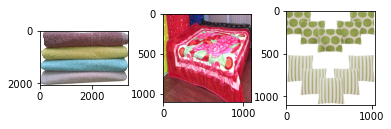

list_Baby


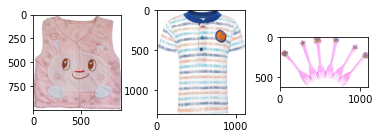

list_Watches


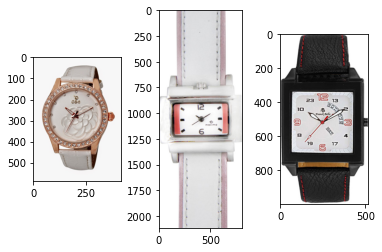

list_Decor


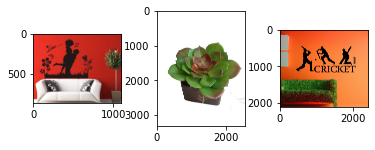

list_Kitchen


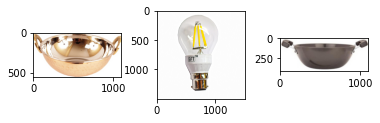

list_Beauty


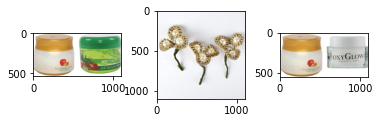

list_Computers


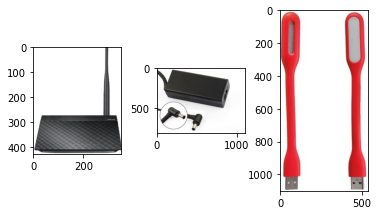

In [115]:
import random

#Liste des catégories
list_labels = [list_Furnishing, list_Baby, list_Watches, list_Decor, list_Kitchen, list_Beauty, 
               list_Computers]
list_label_names = ['list_Furnishing', 'list_Baby', 'list_Watches', 'list_Decor', 'list_Kitchen', 'list_Beauty', 
               'list_Computers']

label_name = "no_name "


#On affiche 3 images par catégorie
for name, list_lab in zip(list_label_names, list_labels) :
    random_pick = random.sample(list_lab, 3)
    print(name)
    # print("-------")
    for i in range(3):
        plt.subplot(130 + 1 + i)
        filename = path + '/' + random_pick[i]
        image = imread(filename)
        plt.imshow(image)
        
    plt.subplots_adjust(wspace=0.4, 
                    hspace=0.4)
    plt.show()

## 1. Algorithme de type SIFT

## Détermination et affichage des descripteurs SIFT

Un descripteur est un vecteur qui décrit le voisinage de la feature à laquelle il est associé. Il est utilisé pour repérer les paires de features qui se ressemblent le plus dans deux images. 

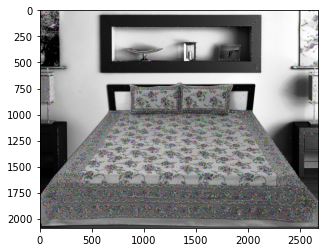

Descripteurs :  (28895, 128)

[[96.  8.  8. ...  0.  0.  0.]
 [28.  6.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ... 33.  1.  6.]
 ...
 [ 1.  0.  0. ...  0.  0.  7.]
 [ 0.  0.  0. ...  0.  0.  5.]
 [ 0.  0.  0. ...  6.  2. 13.]]


In [208]:
import cv2

sift = cv2.xfeatures2d.SIFT_create()
#On charge la deuxième image de notre liste de photos en niveaux de gris
image = cv2.imread(path + '/' + list_photos[4],0) 

#On égalize l'histogramme de l'image
image = cv2.equalizeHist(image)  


#On détecte les points clés et calcule leurs descripteurs 
kp, des = sift.detectAndCompute(image, None)
#On dessine les points clés détectés sur l'image donnée
img=cv2.drawKeypoints(image,kp,image)
#affichage de l'image
plt.imshow(img)
plt.show()
print("Descripteurs : ", des.shape)
print()
print(des)

On en déduit que l'image contient 47651 descripteurs et que chaque descripteur est un vecteur de longueur 128.

Voyons l'histogramme de cette image :

In [205]:
#Fonction qui trace l'histogramme d'une image

from skimage import exposure
from skimage.io import imread, imshow
from skimage.color import rgb2gray

def imageHist(image):
    _, axis = plt.subplots(ncols=2, figsize=(12, 3))
    if (image.ndim == 2):
        # Grascale Image
        axis[0].imshow(image, cmap=plt.get_cmap('gray'))
        axis[1].set_title('Histogram')
        axis[0].set_title('Grayscale Image')
        hist = exposure.histogram(image)
        axis[1].plot(hist[0])
    else:
        # Color image
        axis[0].imshow(image, cmap='gray')
        axis[1].set_title('Histogram')
        axis[0].set_title('Colored Image')
        rgbcolors = ['red', 'green', 'blue']
        for i, mycolor in enumerate(rgbcolors):
            axis[1].plot(exposure.histogram(image[...,i])[0], color=mycolor)

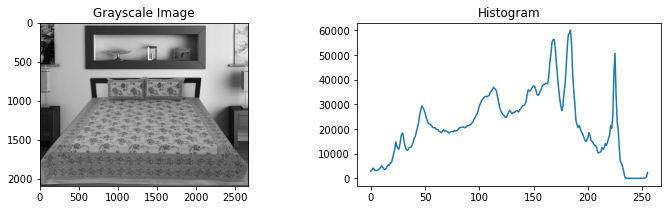

In [214]:
#Exemple d'image
image = cv2.imread(path + '/' + list_photos[4],0) 
#Affichage de l'image et de l'histogramme de cette image
imageHist(image)

Dans cette image en niveau de gris, on voit que la majorité des pixels ont une intensité de 150 à 220. 

# 2. Pré-traitement des images via SIFT

## Créations des descripteurs de chaque image

* Pour chaque image, nous allons les passer en gris et procéder à une equalisation.
* Puis, nous créerons une liste de descripteurs par image ("sift_keypoints_by_img") qui sera utilisée pour réaliser les histogrammes par image.
* Et enfin, l'étape suivante sera la création d'une liste de descripteurs pour l'ensemble des images ("sift_keypoints_all") qui sera utilisé pour créer les clusters de descripteurs.

In [82]:
# On identifie les points clés et leurs descripteurs associés
import time, cv2
sift_keypoints = []
temps1=time.time()
sift = cv2.xfeatures2d.SIFT_create(500)

#Pour chaque image :
for image_num in range(len(list_photos)) :
    if image_num%100 == 0 : print(image_num)
    # convertion en niveau de gris
    image = cv2.imread(path+ '/' + list_photos[image_num],0) 
    # On égalise l'histogramme de l'image
    res = cv2.equalizeHist(image) 
    #On détecte les descripteurs
    kp, des = sift.detectAndCompute(res, None)
    sift_keypoints.append(des)

sift_keypoints_by_img = np.asarray(sift_keypoints)
sift_keypoints_all    = np.concatenate(sift_keypoints_by_img, axis=0)

print()
print("Nombre de descripteurs : ", sift_keypoints_all.shape)

#On calcule le temps de traitement
duration1=time.time()-temps1
print("temps de traitement SIFT descriptor : ", "%15.2f" % duration1, "secondes")

0
100
200
300
400
500
600
700
800
900
1000

Nombre de descripteurs :  (517351, 128)
temps de traitement SIFT descriptor :          2382.82 secondes


On remarque que l'on retrouve bien un vecteur de taille 128.</br>
En effet, chacune de nos images sont découpées en 16 petites fenêtres, et pour chaque fenêtre, on contruit un histogramme (
donc 16 histogrammes en tout).</br>
Chaque histogramme contient 8 valeurs, il y a donc 128 valeurs en tout.</br>
On stocke ces valeurs dans un vecteur (de taille 128), et ce vecteur représente notre descripteur SIFT.

## Création des clusters de descripteurs

On applique ensuite un clustering aux descripteurs de features.
    Cela permet de créer un dictionnaire de visual words, ou bag of features.	


Utilisation de MiniBatchKMeans pour obtenir des temps de traitement raisonnables

In [200]:
from sklearn import cluster, metrics

# Determination number of clusters
temps1=time.time()

k = int(round(np.sqrt(len(sift_keypoints_all)),0))
print("Nombre de clusters estimés : ", k)
print("Création de",k, "clusters de descripteurs ...")

# Clustering
kmeans = cluster.MiniBatchKMeans(n_clusters=k, init_size=3*k, random_state=0)
kmeans.fit(sift_keypoints_all)

duration1=time.time()-temps1
print("temps de traitement kmeans : ", "%15.2f" % duration1, "secondes")

Nombre de clusters estimés :  719
Création de 719 clusters de descripteurs ...
temps de traitement kmeans :            18.01 secondes


## Création des features des images

* Pour chaque image : 
   - On prédit les numéros de cluster de chaque descripteur
   - On crée un histogramme qui correspond au comptage pour chaque numéro de cluster du nombre de descripteurs de l'image

Pour chaque features d'une image, on associe un Histogramme d'une image (correspondant au comptage pour une image du nombre de descripteurs par cluster).

In [84]:
# Creation des histogrammes (features)
temps1=time.time()

def build_histogram(kmeans, des, image_num):
    res = kmeans.predict(des)
    hist = np.zeros(len(kmeans.cluster_centers_))
    nb_des=len(des)
    if nb_des==0 : print("problème histogramme image  : ", image_num)
    for i in res:
        hist[i] += 1.0/nb_des
    return hist


# Creation de matrice d'histogramme
hist_vectors=[]

for i, image_desc in enumerate(sift_keypoints_by_img) :
    if i%100 == 0 : print(i)  
     #calcul de l'histogramme
    hist = build_histogram(kmeans, image_desc, i)
    #Création de l'ensemble des vecteurs d'histogrammes
    hist_vectors.append(hist) 

im_features = np.asarray(hist_vectors)

#Calcul du temps de création des histogrammes
duration1=time.time()-temps1
print("temps de création histogrammes : ", "%15.2f" % duration1, "secondes")

0
100
200
300
400
500
600
700
800
900
1000
temps de création histogrammes :            11.57 secondes


In [197]:
#Crétion de l'histogramme de l'image 1 sous forme de matrice
build_histogram(kmeans, des, 1)

array([0.   , 0.   , 0.002, 0.006, 0.   , 0.012, 0.002, 0.   , 0.   ,
       0.   , 0.   , 0.008, 0.002, 0.   , 0.   , 0.   , 0.   , 0.002,
       0.002, 0.   , 0.014, 0.   , 0.002, 0.   , 0.   , 0.   , 0.   ,
       0.002, 0.   , 0.006, 0.   , 0.   , 0.   , 0.   , 0.004, 0.002,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.002, 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.004, 0.004, 0.   , 0.002, 0.   , 0.   ,
       0.   , 0.   , 0.006, 0.002, 0.   , 0.   , 0.002, 0.   , 0.004,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.004, 0.   , 0.002, 0.   ,
       0.002, 0.   , 0.   , 0.   , 0.   , 0.006, 0.006, 0.   , 0.016,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.004, 0.002, 0.   , 0.   , 0.   , 0.   ,
       0.002, 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.004,
       0.012, 0.004, 0.   , 0.008, 0.   , 0.   , 0.   , 0.002, 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.002, 0.   , 0.   , 0.   , 0.004,
       0.   , 0.   ,

## Réductions de dimension

### Réduction de dimension ACP
* La réduction PCA permet de créer des features décorrélées entre elles, et de diminuer leur dimension, tout en gardant un niveau de variance expliquée élevé (99%)
* L'impact est une meilleure séparation des données via le T-SNE et une réduction du temps de traitement du T-SNE

In [85]:
from sklearn import manifold, decomposition

print("Dimensions dataset avant réduction PCA : ", im_features.shape)
pca = decomposition.PCA(n_components=0.99)
feat_pca= pca.fit_transform(im_features)
print("Dimensions dataset après réduction PCA : ", feat_pca.shape)

Dimensions dataset avant réduction PCA :  (1050, 719)
Dimensions dataset après réduction PCA :  (1050, 498)


### Réduction de dimension T-SNE
* Réduction de dimension en 2 composantes T-SNE pour affichage en 2D des images

In [86]:
from sklearn import manifold, decomposition

tsne = manifold.TSNE(n_components=2, perplexity=30, 
                     n_iter=2000, init='random', random_state=6)
X_tsne = tsne.fit_transform(feat_pca)

df_tsne = pd.DataFrame(X_tsne[:,0:2], columns=['tsne1', 'tsne2'])
df_tsne["class"] = data_I['niveau_categorie_1']
print(df_tsne.shape)


(1050, 3)


In [87]:
df_tsne

tsne1      tsne2                       class
0    -18.504570   4.322603             Home Furnishing
1      2.174441  23.786961                   Baby Care
2     -1.795469   8.441588                   Baby Care
3     -1.218591  30.415459             Home Furnishing
4      1.218461  23.985441             Home Furnishing
5    -22.182623  23.265139                     Watches
6      0.651376   6.849803                     Watches
7    -21.088263  22.464098                     Watches
8    -30.055239 -17.932571                     Watches
9    -21.313478  18.055164                     Watches
10    11.584179 -19.811428                     Watches
11   -16.476419  -0.785654                     Watches
12    31.337130   0.000389                     Watches
13   -18.506454   0.360520                     Watches
14    12.845511 -34.089397                     Watches
15     3.471306  -4.675755                     Watches
16   -11.976958 -15.786284                     Watches
17    22.601627   5.844600                     Watches
18   -31.780308   6.309069                     Watches
19    17.859009  13.781091                     Watches
20   -25.547117  16.056135                     Watches
21    -8.510256   5.325484                     Watches
22   -21.061428  -5.634821                     Watches
23   -28.203979  16.285227                     Watches
24   -38.645798  -5.746453                     Watches
25   -24.928890  17.497795                     Watches
26   -20.122459  -1.196781                     Watches
27    -8.514066   1.681514                     Watches
28   -23.877268  -4.394476                     Watches
29   -21.669477  22.796434                     Watches
30     3.029177 -14.850896                     Watches
31    21.671139   7.742138                     Watches
32   -21.643456  -3.615648                     Watches
33   -15.501717  13.155524             Home Furnishing
34     8.429810 -40.549778             Home Furnishing
35     6.779639  27.727324             Home Furnishing
36     1.576793 -13.411699  Home Decor & Festive Needs
37     5.603678  -7.931643            Kitchen & Dining
38    27.122372   4.732035            Kitchen & Dining
39    11.396525 -37.209076             Home Furnishing
40    22.916336  13.123344                   Baby Care
41     6.106886  14.125630             Home Furnishing
42     1.412609 -39.639702                   Baby Care
43   -28.967550  -3.568096    Beauty and Personal Care
44    -2.495173 -15.094157            Kitchen & Dining
45     0.730976   1.312616            Kitchen & Dining
46    -2.946268 -14.886117            Kitchen & Dining
47   -18.931103 -12.316519                   Computers
48    -3.875168 -15.121181            Kitchen & Dining
49   -27.675949  -1.879124    Beauty and Personal Care
50    -3.052768 -13.794025            Kitchen & Dining
51    12.128622 -22.571697                   Computers
52   -14.275932   7.601456            Kitchen & Dining
53    21.556488 -17.070576                   Computers
54    21.556322 -17.070616                   Computers
55    21.556591 -17.070541                   Computers
56    15.041667 -11.722621    Beauty and Personal Care
57    10.952096  -6.673920    Beauty and Personal Care
58    12.153846  -6.530010    Beauty and Personal Care
59   -23.790535  -3.026051    Beauty and Personal Care
60   -32.243763  15.414795    Beauty and Personal Care
61    11.348677  -6.672643    Beauty and Personal Care
62   -27.454260  12.064698    Beauty and Personal Care
63    20.019678  21.734249                   Baby Care
64    24.916685   7.191048            Kitchen & Dining
65    24.874714   7.485970            Kitchen & Dining
66    15.577842 -39.759224                   Baby Care
67     5.910906 -38.629734             Home Furnishing
68    13.971179 -11.462440            Kitchen & Dining
69     2.436174   6.579395            Kitchen & Dining
70     6.560679 -36.229477            Kitchen & Dining
71     5.909000 -39.104916             Home Furnis

# 3. Analyse des résultats obtenues

## Visualisation : affichage T-SNE selon catégories d'images

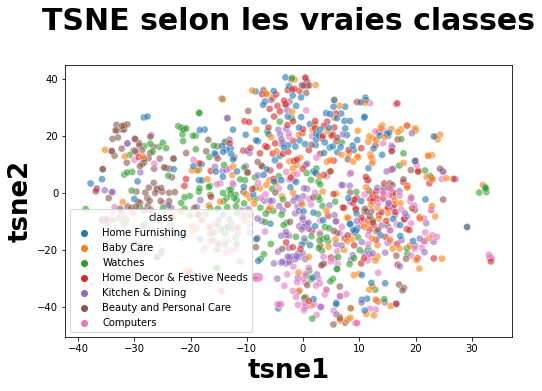

In [88]:
plt.figure(figsize=(8,5))
sns.scatterplot(
    x="tsne1", y="tsne2", hue="class", data=df_tsne, legend="brief",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6)

plt.title('TSNE selon les vraies classes', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
#plt.legend(prop={'size': 14}) 

plt.show()

## Mesures : similarité entre catégories et clusters

###  Création de clusters à partir du T-SNE

In [89]:
from sklearn import cluster, metrics

cls = cluster.KMeans(n_clusters=7, random_state=6)
cls.fit(X_tsne)

df_tsne["cluster"] = cls.labels_
print(df_tsne.shape)

(1050, 4)


###  Affichage des images selon clusters et calcul ARI de similarité catégories images / clusters

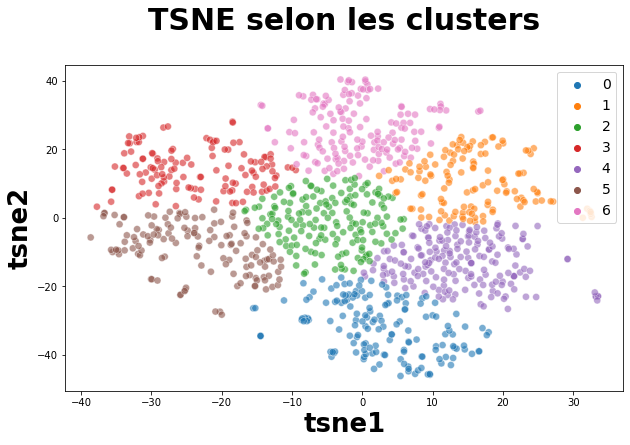

ARI :  0.05457215713424422


In [90]:
#Affichage du tsne selon les clusters
plt.figure(figsize=(10,6))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="cluster",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6,
    data=df_tsne,
    legend="brief")

plt.title('TSNE selon les clusters', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14}) 

plt.show()

#Affichage du score ARI
labels = data_I["code_label"]
print("ARI : ", metrics.adjusted_rand_score(labels, cls.labels_))

### Analyse par classes: matrice de confusion

In [91]:
#Répartitions des clusters
df_tsne.groupby("cluster").count()["class"]

cluster
0    156
1    128
2    163
3    125
4    191
5    134
6    153
Name: class, dtype: int64

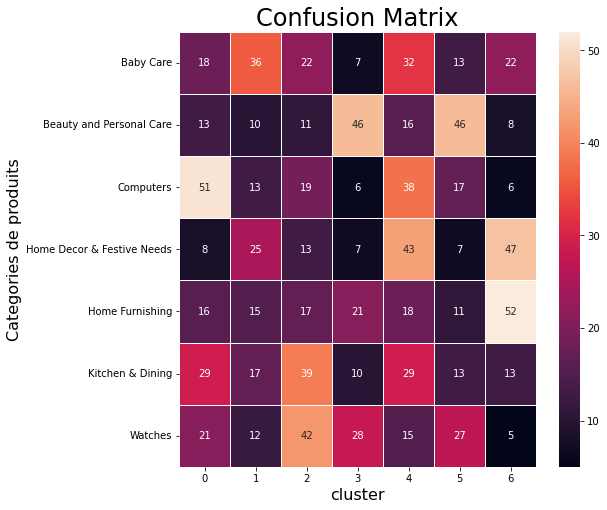

In [123]:
matrice_de_confusion(df_tsne)

Selon cette matrice de confusion, nous voyons que la qualité du système de classification est vraiment mauvaise.
Il n'y a pas de cluster dans lequel nous pourrions retrouver principalement une catégorie.

##  2. Algorithme de type CNN Transfer Learning

Le Transfer Learning (ou apprentissage par transfert) permet de faire du Deep Learning sans avoir besoin d'y passer un mois de calculs. Le principe est d'utiliser les connaissances acquises par un réseau de neurones lors de la résolution d'un problème afin d'en résoudre un autre plus ou moins similaire. On réalise ainsi un transfert de connaissances, d'où le nom.

A l'aide du modèle VGG16, nous allons mettre en oeuvre un algorithme de type CNN Transfer Learning.</br>

VGG-16 est un réseau de neurones convolutif comprenant 16 couches profondes, appelé VGG-Net .

L'image doit être de taille 224×224. 

Dans cette partie, nous allons procéder de la sorte :
* Charger les images et extraire les features,
* Réduire la dimension à l'aide de l'ACP et du TSNE,
* Créer des clusters à l'aide du Kmeans.

### 1_Chargement des images puis extraction des features

In [170]:
from tensorflow import keras

In [168]:
# Implémentation du modèle VGG16

from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.layers import Dense
from keras import Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.utils.np_utils import to_categorical

In [176]:
# Modèle VGG16
model = VGG16(weights='imagenet', include_top=False)

model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [187]:
# Liste
vgg16 = []

data_I['image_loc'] = [path +'/' + row for row in data_I['image']]
for i in data_I['image_loc']:

    # Charger l'image et la redimensionner à la taille
    # requise de 224×224 pixels.
    img = load_img(i, target_size=(224, 224))
    # Convertir les pixels en un tableau NumPy afin de pouvoir travailler
    # avec dans Keras
    img = img_to_array(img)
    # Redimensionnement
    img = np.expand_dims(img, axis=0)
    # Préparer de nouvelles entrées pour le réseau.
    img = preprocess_input(img)

    # obtenir une prédiction de la probabilité d'appartenance
    # de l'image à chacun des 1000 types d'objets connus.
    vgg16_img = model.predict(img)
    # Ajouter la feature prédite en nparray à la liste
    vgg16.append(np.array(vgg16_img).flatten())

vgg16 = np.array(vgg16)

1/1 [==============================] - 0s 397ms/step


1/1 [==============================] - 0s 404ms/step


1/1 [==============================] - 0s 481ms/step


1/1 [==============================] - 1s 522ms/step


In [188]:
# dataframe contenant les bag of visual words du VGG16
data_I['vgg16_B'] = [vgg16[i] for i in range(data_I.shape[0])]
# # Dataframe regroupant les variables nécessaires pour la suite
data_vgg16_B = data_I[['image', 'image_loc', 'niveau_categorie_1', 'vgg16_B']]
# Dataframe de vecteurs de VGG16
data_vgg16_vect = pd.DataFrame.from_records(vgg16)

## 2_Réduction de dimension

**Réduction de dimension ACP**

La réduction PCA permet de créer des features décorrélées entre elles, et de diminuer leur dimension, tout en gardant un niveau de variance expliquée élevé (99%).
L'impact est une meilleure séparation des données via le T-SNE et une réduction du temps de traitement du T-SNE.


In [180]:
print("Dimensions dataset avant réduction PCA : ", data_vgg16_vect.shape)
pca = decomposition.PCA(n_components=0.99)
pca_vgg16 = pca.fit_transform(data_vgg16_vect)
print("Dimensions dataset après réduction PCA : ", pca_vgg16.shape)

Dimensions dataset avant réduction PCA :  (1050, 25088)
Dimensions dataset après réduction PCA :  (1050, 940)


**Réduction de dimension T-SNE**

Réduction de dimension en 2 composantes T-SNE pour affichage en 2D des images

In [189]:
from sklearn import manifold, decomposition

tsne = manifold.TSNE(n_components=2, perplexity=30, 
                     n_iter=2000, init='random', random_state=6)
X_tsne = tsne.fit_transform(pca_results_vgg16)

df_tsne = pd.DataFrame(X_tsne[:,0:2], columns=['tsne1', 'tsne2'])
df_tsne["class"] = data_I["niveau_categorie_1"]
print(df_tsne.shape)

(1050, 3)


In [190]:
df_tsne

tsne1      tsne2                       class
0      9.983974  -8.172958             Home Furnishing
1      6.524434   6.445826                   Baby Care
2      6.556413   0.079751                   Baby Care
3      8.394993   6.583279             Home Furnishing
4     10.251096   0.360614             Home Furnishing
5     -5.504865  24.900225                     Watches
6     -6.936535  24.624708                     Watches
7     -6.612234  24.261320                     Watches
8     -2.401129  23.657339                     Watches
9     -6.242601  20.992634                     Watches
10    -3.130511   6.620903                     Watches
11    -6.304479  20.878054                     Watches
12    -6.785721  22.685129                     Watches
13    -6.794988  22.772615                     Watches
14    -5.974554   7.361921                     Watches
15    -7.693761  23.086298                     Watches
16    -6.361635  -3.499981                     Watches
17    -1.689498   3.636176                     Watches
18    -5.456291  20.548063                     Watches
19    -6.340427  -2.047781                     Watches
20    -3.459050  23.774693                     Watches
21    -4.540644  19.122974                     Watches
22    -7.958426  12.980500                     Watches
23    -2.951361  23.604757                     Watches
24    -6.961348  22.550587                     Watches
25    -2.381438  23.620546                     Watches
26    -3.546866  12.106389                     Watches
27    -1.691551  22.684206                     Watches
28    -1.338409  21.696974                     Watches
29    -6.685382  24.333458                     Watches
30    -0.419353  12.377037                     Watches
31    -5.843473  22.463587                     Watches
32    -8.835171  18.445560                     Watches
33     0.819890   7.242175             Home Furnishing
34     6.294868  12.782043             Home Furnishing
35     6.313674   3.367080             Home Furnishing
36    -0.160418   0.274625  Home Decor & Festive Needs
37    -8.488493  -6.323745            Kitchen & Dining
38    -2.608994   0.554228            Kitchen & Dining
39     6.976605  -2.302429             Home Furnishing
40     9.212023   3.908901                   Baby Care
41     9.576905  -2.870183             Home Furnishing
42     9.243586   3.869210                   Baby Care
43    -4.228445  -9.246164    Beauty and Personal Care
44   -16.798119  -9.245559            Kitchen & Dining
45   -17.153513  -9.247808            Kitchen & Dining
46   -16.965601  -9.259987            Kitchen & Dining
47     0.023302  -3.020058                   Computers
48   -16.842463  -9.259590            Kitchen & Dining
49     0.685581  -6.326393    Beauty and Personal Care
50    -8.085636 -22.322340            Kitchen & Dining
51    -4.431852   3.603659                   Computers
52    -5.226774   0.466676            Kitchen & Dining
53   -15.996965   0.468161                   Computers
54   -15.997262   0.468965                   Computers
55   -15.997395   0.468238                   Computers
56    -6.973194   8.667144    Beauty and Personal Care
57   -14.502466   3.704968    Beauty and Personal Care
58   -14.501087   3.705272    Beauty and Personal Care
59     7.316428 -14.819384    Beauty and Personal Care
60     0.292514  -2.488294    Beauty and Personal Care
61   -14.501838   3.704838    Beauty and Personal Care
62     3.812636  -9.960785    Beauty and Personal Care
63    12.594516   3.029761                   Baby Care
64   -17.812929 -11.134921            Kitchen & Dining
65   -17.803295 -11.158819            Kitchen & Dining
66     9.437510  -5.266838                   Baby Care
67    16.395102   6.989132             Home Furnishing
68    -0.455554   1.816313            Kitchen & Dining
69     4.583685  -7.841340            Kitchen & Dining
70     1.941366   9.099417            Kitchen & Dining
71    16.432100   7.001515             Home Furnis

## 3_ Analyse des résultats obtenues

## Visualisation : affichage T-SNE selon catégories d'images

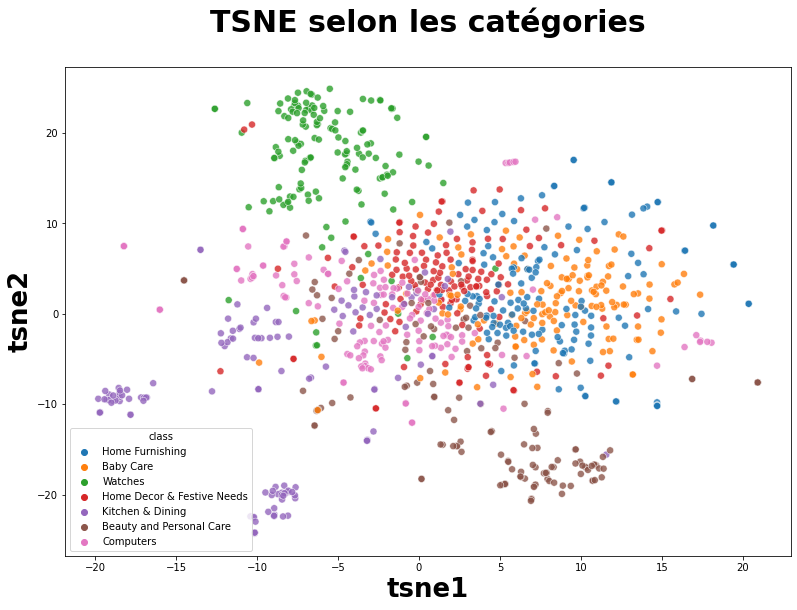

In [194]:
plt.figure(figsize=(13,9))
sns.scatterplot(
    x="tsne1", y="tsne2", hue="class", data=df_tsne_vgg16, legend="brief",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.8)

plt.title('TSNE selon les catégories', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
 

plt.show()

Les catégories sont mieux regroupés que ce que nous avions eu avec l'algorithme SIFT.

## Mesures : similarité entre catégories et clusters

###  Création de clusters à partir du T-SNE

In [195]:
#Création de clusters à partir du T-SNE 
X = df_tsne[["tsne1","tsne2"]]

cls = cluster.KMeans(n_clusters=7, init='k-means++', random_state=0)
cls.fit(X)

df_tsne["cluster"] = cls.labels_


### Affichage des images selon clusters et calcul ARI de similarité catégories images / clusters

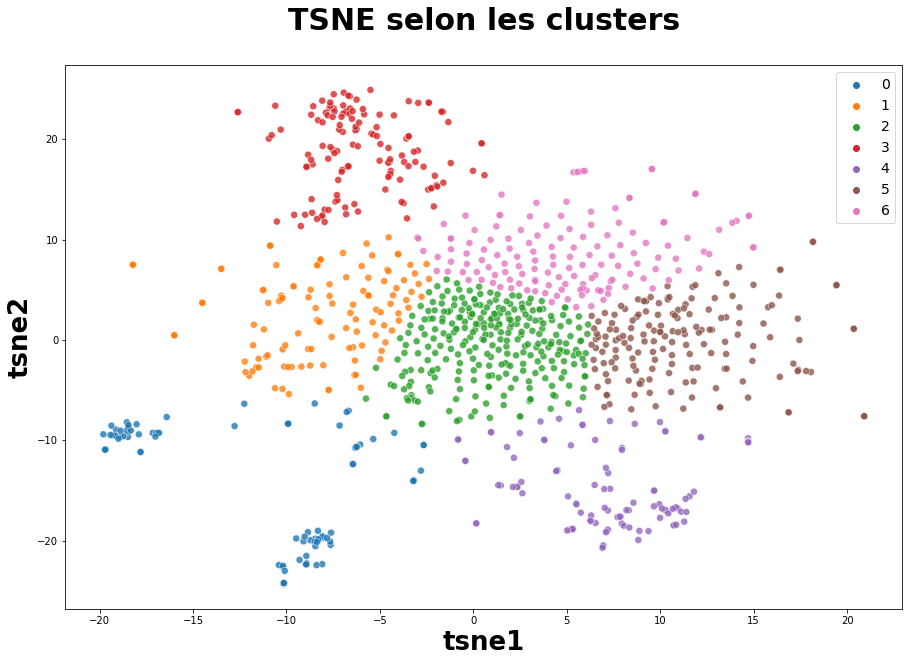

ARI :  0.29055279528843414


In [196]:
#Affichage des images selon clusters
plt.figure(figsize=(15,10))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="cluster",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.8,
    data=df_tsne_vgg16,
    legend="brief")

plt.title('TSNE selon les clusters', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14}) 

plt.show()

# calcul du score ARI qui mesure la similarité entre les catégories et les clusters
labels = data_I["code_label"]
print("ARI : ", metrics.adjusted_rand_score(labels, cls.labels_))

Si nous comparons avec le score ARI du modèle SIFT, nous voyons que celui ci est plus important. </br>
Rappel : Celui de SIFT était de 0.05.


### Matrice de confusion


In [185]:
df_tsne_vgg16.groupby("cluster").count()["class"]

cluster
0     98
1    126
2    274
3    133
4    106
5    168
6    145
Name: class, dtype: int64

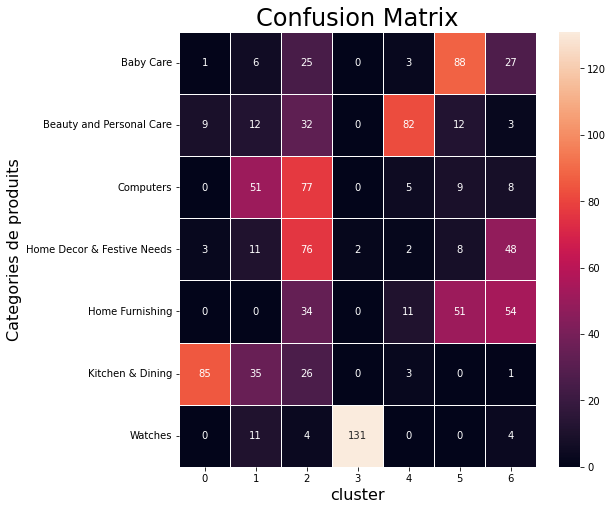

In [186]:
matrice_de_confusion(df_tsne_vgg16)

La qualité du système de classification est meilleure an utilisant l'algoritme type CNN Tranfer Learning.

## Conclusions 



Nous avons classifier nos données textuelles et images. Cela a été fait sur un échantillon de 1050 produits.

On remarque que la classification sur la partie texte est plus satisfaisante, que celle des images.

Cela pourrait être amélioré par exemple par une classification faite sur des produits avec des textes et images associés.

On peut donc dire que l'étude de faisabilité est positive.
